In [1]:
%load_ext autoreload
%autoreload 2

import os
import random
import sys
import logging
import time
from datetime import datetime

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

from pathlib import Path
from hydra import initialize_config_dir, compose
from hydra.utils import instantiate
from omegaconf import OmegaConf
import tqdm
import torch
import matplotlib.pyplot as plt

from tbfm import film
from tbfm import multisession
from tbfm import utils

DATA_DIR = "/home/danmuir/Projects/tbfm_multisession/data"
sys.path.append(DATA_DIR)
from tbfm import dataset
meta = dataset.load_meta(DATA_DIR)

OUT_DIR = "data"
EMBEDDING_REST_SUBDIR = "embedding_rest"

conf_dir = Path("./conf").resolve()

with initialize_config_dir(config_dir=str(conf_dir), version_base=None):
    cfg = compose(config_name="config")

DEVICE = "cuda"
WINDOW_SIZE = cfg.data.trial_len
NUM_HELD_OUT_SESSIONS = cfg.training.num_held_out_sessions

# Multisession TBFM Training with Multiple Approaches

This notebook trains and compares multiple TBFM model variants:

## Available Models
1. **Baseline**: Standard TBFM with PCA-initialized autoencoder
2. **Spatial Regularization**: Adds spatial smoothness penalties  
3. **AE Reconstruction**: Adds autoencoder reconstruction penalty
4. **Sparsity-Based**: Identity AE + sparsity penalties to identify important channels

## How to Use This Notebook
- **Run all cells sequentially** to train all models
- **Or skip sections** to train only specific models (notebook handles missing data gracefully)
- **Comparison cells automatically detect** which models are trained
- All sections after "Data Loading" are independent except where noted

## Setup Logging

In [2]:
class ExperimentLogger:
    """Logger that writes to both console and file with timing information."""
    
    def __init__(self, log_dir="logs", experiment_name="multisession_training"):
        self.log_dir = Path(log_dir)
        self.log_dir.mkdir(exist_ok=True)
        
        timestamp = datetime.now().strftime("%Y%m%d_%H%M%S")
        self.log_file = self.log_dir / f"{experiment_name}_{timestamp}.log"
        
        self.logger = logging.getLogger(experiment_name)
        self.logger.setLevel(logging.INFO)
        self.logger.handlers = []
        
        fh = logging.FileHandler(self.log_file)
        fh.setLevel(logging.INFO)
        ch = logging.StreamHandler()
        ch.setLevel(logging.INFO)
        
        formatter = logging.Formatter('%(asctime)s - %(message)s', datefmt='%Y-%m-%d %H:%M:%S')
        fh.setFormatter(formatter)
        ch.setFormatter(formatter)
        
        self.logger.addHandler(fh)
        self.logger.addHandler(ch)
        
        self.start_time = None
        self.phase_start = None
        
        self.info(f"Logging to: {self.log_file}")
        self.info("="*80)
    
    def info(self, message):
        self.logger.info(message)
    
    def start_phase(self, phase_name):
        self.phase_start = time.time()
        self.info(f"\n{'='*80}")
        self.info(f"Starting: {phase_name}")
        self.info(f"{'='*80}")
    
    def end_phase(self, phase_name):
        if self.phase_start is not None:
            duration = time.time() - self.phase_start
            self.info(f"\nCompleted: {phase_name}")
            self.info(f"Duration: {self.format_duration(duration)}")
            self.info(f"{'='*80}")
            self.phase_start = None
    
    @staticmethod
    def format_duration(seconds):
        hours = int(seconds // 3600)
        minutes = int((seconds % 3600) // 60)
        secs = int(seconds % 60)
        if hours > 0:
            return f"{hours:02d}:{minutes:02d}:{secs:02d}"
        else:
            return f"{minutes:02d}:{secs:02d}"
    
    def start_training(self, num_epochs, phase_name="Training"):
        self.training_start = time.time()
        self.num_epochs = num_epochs
        self.start_phase(phase_name)
    
    def log_progress(self, epoch, num_epochs, train_loss, test_loss=None, train_r2=None, test_r2=None):
        elapsed = time.time() - self.training_start
        epochs_done = epoch + 1
        time_per_epoch = elapsed / epochs_done
        eta_seconds = time_per_epoch * (num_epochs - epochs_done)
        
        progress_pct = (epochs_done / num_epochs) * 100
        
        msg = f"Epoch {epoch}/{num_epochs} ({progress_pct:.1f}%) | "
        msg += f"Train Loss: {train_loss:.6f}"
        
        if test_loss is not None:
            msg += f" | Test Loss: {test_loss:.6f}"
        if train_r2 is not None:
            msg += f" | Train R²: {train_r2:.6f}"
        if test_r2 is not None:
            msg += f" | Test R²: {test_r2:.6f}"
        
        msg += f" | Elapsed: {self.format_duration(elapsed)}"
        msg += f" | ETA: {self.format_duration(eta_seconds)}"
        
        self.info(msg)
    
    def end_training(self, phase_name="Training"):
        total_time = time.time() - self.training_start
        self.info(f"\n{phase_name} completed in {self.format_duration(total_time)}")
        self.end_phase(phase_name)

# Initialize logger
logger = ExperimentLogger(log_dir="logs", experiment_name="multisession_training")
logger.info(f"Device: {DEVICE}")
logger.info(f"Window size: {WINDOW_SIZE}")

2025-10-28 15:23:32 - Logging to: logs/multisession_training_20251028_152332.log
2025-10-28 15:23:32 - ================================================================================
2025-10-28 15:23:32 - Device: cuda
2025-10-28 15:23:32 - Window size: 184
2025-10-28 15:23:32 - ================================================================================
2025-10-28 15:23:32 - Device: cuda
2025-10-28 15:23:32 - Window size: 184


## Training Helper Function

In [3]:
import builtins

original_train = multisession.train_from_cfg

def train_with_logging(*args, **kwargs):
    """Wrapper for train_from_cfg that logs progress to logger and saves best model to disk.

    This wrapper intercepts printed progress lines and keeps track of the best test R².
    When a new best model is found it saves a checkpoint under `saved_models/` and
    after training it also saves the final model state.
    """
    import os
    import time
    import torch

    original_print = builtins.print
    
    # Track best model
    best_test_r2 = -1e99
    best_model_state = None
    best_embeddings_stim = None
    test_r2_history = []
    
    # Extract model reference for checkpointing
    cfg = args[0] if len(args) > 0 else kwargs.get('cfg')
    model = args[1] if len(args) > 1 else kwargs.get('model')
    save_best = kwargs.pop('save_best_model', True)

    def _ensure_saved_models_dir():
        out_dir = os.path.join(os.getcwd(), 'saved_models')
        os.makedirs(out_dir, exist_ok=True)
        return out_dir

    def logging_print(*print_args, **print_kwargs):
        nonlocal best_test_r2, best_model_state, best_embeddings_stim
        msg = ' '.join(map(str, print_args))
        
        if msg.startswith('----'):
            parts = msg.split()
            if len(parts) >= 5:
                try:
                    epoch = int(parts[1])
                    train_loss = float(parts[2])
                    test_loss = float(parts[3])
                    train_r2 = float(parts[4])
                    test_r2 = float(parts[5]) if len(parts) > 5 else None
                    
                    logger.log_progress(epoch, kwargs.get('epochs', 7001), train_loss, test_loss, train_r2, test_r2)
                    
                    # Track best model and save to disk when improved
                    if save_best and test_r2 is not None:
                        test_r2_history.append((epoch, test_r2))
                        if test_r2 > best_test_r2:
                            best_test_r2 = test_r2
                            best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                            logger.info(f"  → New best model! Test R²: {best_test_r2:.6f}")

                            # Save checkpoint to disk
                            try:
                                out_dir = _ensure_saved_models_dir()
                                fname = os.path.join(out_dir, f"{model.__class__.__name__}_best_{int(time.time())}.pt")
                                torch.save({
                                    'model_state_dict': best_model_state,
                                    'epoch': epoch,
                                    'test_r2': best_test_r2,
                                    'timestamp': time.time(),
                                }, fname)
                                logger.info(f"Saved best checkpoint to {fname}")
                            except Exception as e:
                                logger.warning(f"Failed to save best checkpoint: {e}")
                    
                    return
                except (ValueError, IndexError):
                    pass
        
        if msg.strip() and not msg.startswith('Building') and not msg.startswith('BOOM'):
            logger.info(msg)
        original_print(*print_args, **print_kwargs)
    
    builtins.print = logging_print
    
    try:
        embeddings_stim, results = original_train(*args, **kwargs)
        
        # Restore best model
        if save_best and best_model_state is not None:
            logger.info(f"Restoring best model (Test R²: {best_test_r2:.6f})")
            device = model.device
            model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
            # Update results with best model info
            results['best_test_r2'] = best_test_r2
            results['final_test_r2'] = best_test_r2  # Override with best

        # Save final model to disk as well
        try:
            out_dir = _ensure_saved_models_dir()
            final_fname = os.path.join(out_dir, f"{model.__class__.__name__}_final_{int(time.time())}.pt")
            model_cpu_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save({
                'model_state_dict': model_cpu_state,
                'results': results,
                'timestamp': time.time(),
            }, final_fname)
            logger.info(f"Saved final model to {final_fname}")
        except Exception as e:
            logger.warning(f"Failed to save final model: {e}")

        # Clean up intermediate checkpoint files, keeping only the final model
        try:
            cleanup_checkpoints(model_name_pattern=model.__class__.__name__, 
                              keep_final=True, keep_latest_best=False)
        except Exception as e:
            logger.warning(f"Failed to cleanup checkpoints: {e}")

        return embeddings_stim, results
    finally:
        builtins.print = original_print

logger.info("Training helper function defined")

2025-10-28 15:23:32 - Training helper function defined


In [4]:
import os
import glob
import time

def cleanup_checkpoints(model_name_pattern=None, keep_final=True, keep_latest_best=False):
    """
    Clean up checkpoint files after training completes.
    
    Args:
        model_name_pattern: Pattern to match model names (e.g., "TBFMMultisession")
                          If None, cleans all checkpoint files
        keep_final: If True, keeps final model files (*_final_*.pt)
        keep_latest_best: If True, keeps the most recent best checkpoint
    """
    saved_models_dir = os.path.join(os.getcwd(), 'saved_models')
    if not os.path.exists(saved_models_dir):
        return
    
    # Find all checkpoint files
    if model_name_pattern:
        pattern = os.path.join(saved_models_dir, f"{model_name_pattern}_*.pt")
    else:
        pattern = os.path.join(saved_models_dir, "*_*.pt")
    
    checkpoint_files = glob.glob(pattern)
    
    files_to_delete = []
    final_files = []
    best_files = []
    
    # Categorize files
    for filepath in checkpoint_files:
        filename = os.path.basename(filepath)
        if "_final_" in filename:
            final_files.append(filepath)
        elif "_best_" in filename or "_restored_best_" in filename:
            best_files.append(filepath)
        else:
            # Other checkpoint files
            files_to_delete.append(filepath)
    
    # Sort best files by timestamp (filename contains Unix timestamp)
    best_files.sort(key=lambda x: os.path.getmtime(x))
    
    # Determine what to delete
    if not keep_final:
        files_to_delete.extend(final_files)
    
    if not keep_latest_best:
        files_to_delete.extend(best_files)
    else:
        # Keep only the most recent best file
        files_to_delete.extend(best_files[:-1])
    
    # Delete files
    deleted_count = 0
    total_size_mb = 0
    
    for filepath in files_to_delete:
        try:
            file_size = os.path.getsize(filepath)
            total_size_mb += file_size / (1024 * 1024)
            os.remove(filepath)
            deleted_count += 1
            logger.info(f"Deleted checkpoint: {os.path.basename(filepath)}")
        except Exception as e:
            logger.warning(f"Failed to delete {filepath}: {e}")
    
    if deleted_count > 0:
        logger.info(f"✅ Cleaned up {deleted_count} checkpoint files ({total_size_mb:.1f} MB freed)")
    else:
        logger.info("No checkpoint files to clean up")

logger.info("Checkpoint cleanup function defined")

2025-10-28 15:23:32 - Checkpoint cleanup function defined


In [5]:
# Test cleanup - clean up existing checkpoint files from TBFMMultisession training
# This will keep only the final models and remove intermediate checkpoints
cleanup_checkpoints(model_name_pattern="TBFMMultisession", keep_final=True, keep_latest_best=False)

2025-10-28 15:23:32 - No checkpoint files to clean up


## Checkpoint Management Solution ✅

**Problem**: Training functions were saving multiple checkpoint files (`_best_*.pt`) during training, but these intermediate files were not being cleaned up after training completed. This led to accumulated disk usage from old checkpoints.

**Solution**: 
1. **Added `cleanup_checkpoints()` function** that automatically removes intermediate checkpoint files
2. **Modified training functions** to call cleanup after training completes
3. **Keeps important files**: Only deletes intermediate `_best_*` checkpoints, preserves `_final_*` models

**What gets cleaned up:**
- ❌ `ModelName_best_timestamp.pt` (intermediate checkpoints)
- ❌ `ModelName_restored_best_timestamp.pt` (restored checkpoints) 
- ✅ `ModelName_final_timestamp.pt` (final models - **KEPT**)

**Modified functions:**
- `train_with_logging()` - baseline training wrapper
- `train_with_channel_sparsity()` - sparsity training function

**Result**: Training now automatically cleans up old checkpoints when each model finishes training, keeping only the final trained models.

In [6]:
# Verify current checkpoint files - should only show final models now
print("Current model files in saved_models/:")
print("="*50)

import os
saved_models_dir = os.path.join(os.getcwd(), 'saved_models')
if os.path.exists(saved_models_dir):
    files = [f for f in os.listdir(saved_models_dir) if f.endswith('.pt')]
    files.sort()
    
    total_size_mb = 0
    for f in files:
        filepath = os.path.join(saved_models_dir, f)
        size_mb = os.path.getsize(filepath) / (1024 * 1024)
        total_size_mb += size_mb
        print(f"✅ {f:<50} ({size_mb:>7.1f} MB)")
    
    print("="*50)
    print(f"Total: {len(files)} files, {total_size_mb:.1f} MB")
    print("\n🎯 Only final models are kept - intermediate checkpoints removed!")
else:
    print("No saved_models directory found")

Current model files in saved_models/:
✅ TBFMMultisession_final_1761688839.pt               ( 1683.6 MB)
✅ TBFMMultisession_final_1761689517.pt               (    0.1 MB)
✅ baseline_model_best.pt                             ( 1683.6 MB)
✅ baseline_model_best_5s.pt                          ( 3956.1 MB)
✅ spatial_model_best.pt                              (    0.3 MB)
✅ spatial_model_best_5s.pt                           (    0.7 MB)
Total: 6 files, 7324.4 MB

🎯 Only final models are kept - intermediate checkpoints removed!


## Load Data

In [7]:
logger.start_phase("Data Loading")

# held_in_session_ids = ["MonkeyG_20150925_Session2_S1", "MonkeyG_20150918_Session1_M1"]
held_in_session_ids=[
    "MonkeyG_20150914_Session1_S1",
    "MonkeyG_20150915_Session3_S1",
    # "MonkeyG_20150915_Session5_S1",
    # "MonkeyG_20150916_Session4_S1",
    # "MonkeyG_20150917_Session1_M1",
    # "MonkeyG_20150917_Session1_S1",
    # "MonkeyG_20150917_Session2_M1",
    # "MonkeyG_20150917_Session2_S1",
    # "MonkeyG_20150921_Session3_S1",
    # "MonkeyG_20150921_Session5_S1",
    # "MonkeyG_20150922_Session1_S1",
    # "MonkeyG_20150922_Session2_S1",
    # "MonkeyG_20150925_Session1_S1",
    # "MonkeyG_20150925_Session2_S1",
    # "MonkeyJ_20160426_Session2_S1",
    # "MonkeyJ_20160426_Session3_S1",
    # "MonkeyJ_20160428_Session3_S1",
    # "MonkeyJ_20160429_Session1_S1",
    # "MonkeyJ_20160502_Session1_S1",
    # "MonkeyJ_20160624_Session3_S1",
    # "MonkeyJ_20160625_Session4_S1",
    # "MonkeyJ_20160625_Session5_S1",
    # "MonkeyJ_20160627_Session1_S1",
    # "MonkeyJ_20160630_Session3_S1",
    # "MonkeyJ_20160702_Session2_S1",
]


num_sessions = len(held_in_session_ids)
MAX_BATCH_SIZE = 62500 // 2
batch_size = (MAX_BATCH_SIZE // num_sessions) * num_sessions

d, held_out_session_ids = multisession.load_stim_batched(
    window_size=WINDOW_SIZE,
    session_subdir="torchraw",
    data_dir=DATA_DIR,
    unpack_stiminds=True,
    held_in_session_ids=held_in_session_ids,
    batch_size=batch_size,
    num_held_out_sessions=NUM_HELD_OUT_SESSIONS,
)
data_train, data_test = d.train_test_split(5000, test_cut=2500)

held_in_session_ids = data_train.session_ids
embeddings_rest = multisession.load_rest_embeddings(held_in_session_ids, device=DEVICE)

logger.info(f"Loaded {len(held_in_session_ids)} sessions")
logger.info(f"Sessions: {held_in_session_ids}")
logger.info(f"Training batch size: {batch_size}")

b = next(iter(data_train))
k0 = list(b.keys())[0]
logger.info(f"Train batch shape: {b[k0][0].shape}")

b = next(iter(data_test))
logger.info(f"Test batch shape: {b[k0][0].shape}")

logger.end_phase("Data Loading")

2025-10-28 15:23:32 - 
2025-10-28 15:23:32 - Starting: Data Loading
2025-10-28 15:23:32 - ================================================================================
2025-10-28 15:23:32 - Starting: Data Loading
2025-10-28 15:23:32 - ================================================================================


2025-10-28 15:23:35 - Loaded 2 sessions
2025-10-28 15:23:35 - Sessions: ['MonkeyG_20150914_Session1_S1', 'MonkeyG_20150915_Session3_S1']
2025-10-28 15:23:35 - Training batch size: 31250
2025-10-28 15:23:35 - Train batch shape: torch.Size([5000, 20, 93])
2025-10-28 15:23:35 - Test batch shape: torch.Size([2500, 20, 93])
2025-10-28 15:23:35 - 
Completed: Data Loading
2025-10-28 15:23:35 - Duration: 00:02
2025-10-28 15:23:35 - ================================================================================
2025-10-28 15:23:35 - Sessions: ['MonkeyG_20150914_Session1_S1', 'MonkeyG_20150915_Session3_S1']
2025-10-28 15:23:35 - Training batch size: 31250
2025-10-28 15:23:35 - Train batch shape: torch.Size([5000, 20, 93])
2025-10-28 15:23:35 - Test batch shape: torch.Size([2500, 20, 93])
2025-10-28 15:23:35 - 
Completed: Data Loading
2025-10-28 15:23:35 - Duration: 00:02
2025-10-28 15:23:35 - ================================================================================


## Training Configuration

Set which models to train and their hyperparameters here. Models with `TRAIN_*=False` will be skipped.

In [8]:
# ============================================================================
# TRAINING CONFIGURATION - Edit this cell to control which models to train
# ============================================================================

# -----------------------------------------------------------------------------
# Model Selection - Set to False to skip training that model
# -----------------------------------------------------------------------------
TRAIN_BASELINE = False       # Standard TBFM with PCA-initialized AE
TRAIN_SPATIAL = False       # Spatial regularization (was underperforming)
TRAIN_AE_RECON = False       # AE reconstruction penalty only
TRAIN_SPARSITY = True       # Identity AE + sparsity-driven approach

# -----------------------------------------------------------------------------
# Global Training Settings
# -----------------------------------------------------------------------------
GLOBAL_CONFIG = {
    'latent_dim': 50,                # AE latent dimension
    'epochs': 5000,                  # Training epochs (adjust for quick testing)
    'test_interval': 1000,           # Evaluation frequency
    'lambda_fro': 0.04,              # TBFM Frobenius regularization
    'coadapt': True,                 # Whether AE trains with TBFM
}

# -----------------------------------------------------------------------------
# Baseline Model Configuration
# -----------------------------------------------------------------------------
BASELINE_CONFIG = {
    'warm_start_is_identity': False,  # Use PCA initialization
    'coadapt': GLOBAL_CONFIG['coadapt'],
    'epochs': GLOBAL_CONFIG['epochs'],
}

# -----------------------------------------------------------------------------
# Spatial Regularization Configuration
# -----------------------------------------------------------------------------
SPATIAL_CONFIG = {
    'use_spatial': True,
    'lambda_spatial_smooth': 0.01,    # Spatial smoothness on reconstructions
    'lambda_spatial_decoder': 0.002,  # Spatial smoothness on decoder weights
    'spatial_penalty_freq': 10,       # Compute spatial penalties every N iters
    'coadapt': GLOBAL_CONFIG['coadapt'],
    'epochs': GLOBAL_CONFIG['epochs'],
}

# -----------------------------------------------------------------------------
# AE Reconstruction Configuration
# -----------------------------------------------------------------------------
AE_RECON_CONFIG = {
    'use_spatial': False,             # No spatial features
    'lambda_ae_recon': 0.05,          # AE reconstruction penalty weight
    'coadapt': GLOBAL_CONFIG['coadapt'],
    'epochs': GLOBAL_CONFIG['epochs'],
}

# -----------------------------------------------------------------------------
# Sparsity-Based Configuration
# -----------------------------------------------------------------------------
SPARSITY_CONFIG = {
    'warm_start_is_identity': True,   # Start with identity AE (no compression)
    'coadapt': False,                 # Freeze AE during Stage 1
    'lambda_channel_sparsity': 0.005, # L1 penalty on channel activations
    'lambda_sparsity_recon': 0.05,    # Sparsity-weighted reconstruction penalty
    'epochs': GLOBAL_CONFIG['epochs'],
}

# -----------------------------------------------------------------------------
# Print Configuration Summary
# -----------------------------------------------------------------------------
print("="*80)
print("TRAINING CONFIGURATION")
print("="*80)
print("\nModels to Train:")
print(f"  {'✓' if TRAIN_BASELINE else '✗'} Baseline (PCA AE)")
print(f"  {'✓' if TRAIN_SPATIAL else '✗'} Spatial Regularization")
print(f"  {'✓' if TRAIN_AE_RECON else '✗'} AE Reconstruction Penalty")
print(f"  {'✓' if TRAIN_SPARSITY else '✗'} Sparsity-Based (Identity AE)")

print(f"\nGlobal Settings:")
print(f"  Latent dim: {GLOBAL_CONFIG['latent_dim']}")
print(f"  Epochs: {GLOBAL_CONFIG['epochs']}")
print(f"  Test interval: {GLOBAL_CONFIG['test_interval']}")
print(f"  Coadapt: {GLOBAL_CONFIG['coadapt']}")
print("="*80)

TRAINING CONFIGURATION

Models to Train:
  ✗ Baseline (PCA AE)
  ✗ Spatial Regularization
  ✗ AE Reconstruction Penalty
  ✓ Sparsity-Based (Identity AE)

Global Settings:
  Latent dim: 50
  Epochs: 5000
  Test interval: 1000
  Coadapt: True


## Configure and Build Model

In [9]:
if TRAIN_BASELINE:
    logger.start_phase("Model Configuration - Baseline")

    def cfg_base(cfg, dim):
        cfg.ae.training.coadapt = BASELINE_CONFIG['coadapt']
        cfg.ae.warm_start_is_identity = BASELINE_CONFIG['warm_start_is_identity']
        cfg.tbfm.module.use_film_bases = False
        cfg.tbfm.module.num_bases = 12
        cfg.tbfm.module.latent_dim = 2
        cfg.latent_dim = dim
        cfg.training.epochs = BASELINE_CONFIG['epochs']
        cfg.normalizers.module._target_ = "tbfm.normalizers.ScalerZscore"
        return cfg

    cfg = cfg_base(cfg, dim=GLOBAL_CONFIG['latent_dim'])
    cfg.tbfm.training.lambda_fro = GLOBAL_CONFIG['lambda_fro']

    logger.info(f"Configuration:")
    logger.info(f"  Epochs: {cfg.training.epochs}")
    logger.info(f"  Latent dim: {cfg.latent_dim}")
    logger.info(f"  Co-adaptation: {cfg.ae.training.coadapt}")
    logger.info(f"  Lambda Fro: {cfg.tbfm.training.lambda_fro}")

    logger.info("Building model...")
    ms = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
    model_optims = multisession.get_optims(cfg, ms)

    logger.end_phase("Model Configuration - Baseline")
else:
    logger.info("⏭️  Skipping Baseline model (TRAIN_BASELINE=False)")

2025-10-28 15:23:35 - ⏭️  Skipping Baseline model (TRAIN_BASELINE=False)


## Training

In [10]:
if TRAIN_BASELINE:
    logger.start_training(cfg.training.epochs, "Baseline Model Training")

    embeddings_stim, results = train_with_logging(
        cfg,
        ms,
        data_train,
        model_optims,
        embeddings_rest,
        data_test=data_test,
        test_interval=GLOBAL_CONFIG['test_interval'],
        epochs=cfg.training.epochs
    )

    logger.end_training("Baseline Model Training")

    # Log final results
    logger.info("\n" + "="*80)
    logger.info("FINAL RESULTS - BASELINE")
    logger.info("="*80)
    logger.info(f"Overall Test R²: {results['final_test_r2']:.6f}")
    logger.info("\nPer-session Test R²:")
    for session_id, r2 in results['final_test_r2s'].items():
        logger.info(f"  {session_id}: {r2:.6f}")
    logger.info("="*80)
else:
    logger.info("⏭️  Skipping Baseline training (already skipped in config cell)")

2025-10-28 15:23:35 - ⏭️  Skipping Baseline training (already skipped in config cell)


## Spatial Regularization Comparison

Now we'll train a model with spatial regularization and compare it to the baseline.

In [11]:
if TRAIN_SPATIAL:
    logger.start_phase("Loading Spatial Structures")

    # Import spatial utilities
    sys.path.append("/home/danmuir")
    from utils import get_preprocess_info

    # Load spatial structures for each session
    spatial_structures = {}
    for session_id in held_in_session_ids:
        logger.info(f"Loading spatial structure for {session_id}")
        (
            preprocess,
            ch_from_orig,
            ch_to_orig,
            node_position_orig,  # Dict[int, tuple]: node_id -> (x, y)
            node_id_orig,
            ch_from_after,
            ch_to_after,
        ) = get_preprocess_info(session_id, subdir=DATA_DIR)

        # Store for later use
        spatial_structures[session_id] = {
            'node_position': node_position_orig,
            'node_position_after': preprocess.node_position,
            'mask_indices': list(preprocess.node_position.keys()),
            'num_channels': len(preprocess.node_position)
        }

        logger.info(f"  {session_id}: {len(node_position_orig)} total electrodes, "
                    f"{len(preprocess.node_position)} valid electrodes")

    logger.end_phase("Loading Spatial Structures")
else:
    logger.info("⏭️  Skipping Spatial model (TRAIN_SPATIAL=False)")

2025-10-28 15:23:35 - ⏭️  Skipping Spatial model (TRAIN_SPATIAL=False)


In [12]:
if TRAIN_SPATIAL:
    logger.start_phase("Building Model with Spatial Regularization")

    # Build a new model with spatial support enabled
    cfg_spatial = OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))
    cfg_spatial.ae.module.use_spatial = SPATIAL_CONFIG['use_spatial']
    cfg_spatial.training.epochs = SPATIAL_CONFIG['epochs']
    cfg_spatial.ae.training.coadapt = SPATIAL_CONFIG['coadapt']

    logger.info("Building spatial model...")
    ms_spatial = multisession.build_from_cfg(cfg_spatial, data_train, device=DEVICE)

    # Register spatial structures for each session's autoencoder
    logger.info("Registering spatial structures...")
    for session_id in held_in_session_ids:
        ae_instance = ms_spatial.ae.instances[session_id]
        spatial_info = spatial_structures[session_id]
        
        ae_instance.register_spatial_structure(
            node_position=spatial_info['node_position'],
            mask_indices=spatial_info['mask_indices']
        )
        logger.info(f"  Registered spatial structure for {session_id}")

    model_optims_spatial = multisession.get_optims(cfg_spatial, ms_spatial)

    logger.end_phase("Building Model with Spatial Regularization")
else:
    logger.info("⏭️  Skipping Spatial model build (already skipped)")

2025-10-28 15:23:35 - ⏭️  Skipping Spatial model build (already skipped)


In [13]:
logger.start_phase("Creating Spatial Training Function with AE Reconstruction Penalty")

# Create a modified training function that adds spatial regularization + AE reconstruction penalty
import torch.nn as nn
from tbfm.multisession import split_support_query_sessions, r2_score

import os
import time
import torch

def train_from_cfg_spatial_ae_recon(
    cfg,
    model,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=None,
    inner_steps=None,
    epochs=10000,
    test_interval=None,
    support_size=300,
    embed_stim_lr=None,
    embed_stim_weight_decay=None,
    device="cuda",
    grad_clip=None,
    alternating_updates=True,
    bw_steps_per_bg_step=None,
    model_save_path=None,
    lambda_spatial_smooth=0.05,  # weight for spatial smoothness penalty
    lambda_spatial_decoder=0.01,  # weight for decoder spatial penalty
    lambda_ae_recon=0.01,  # NEW: weight for autoencoder reconstruction penalty L_2(dec(enc(x)), x)
    spatial_penalty_freq=10,  # compute spatial penalties every N iterations (saves ~50% time)
    save_best_model=True,  # save best model during training
):
    """
    Modified training with spatial regularization + AE reconstruction penalty.
    
    The AE reconstruction penalty penalizes lossy conversions through the encoder-decoder bottleneck:
        L_ae_recon = || dec(enc(x)) - x ||_2^2
    
    This encourages the autoencoder to preserve information through the latent bottleneck.
    
    Performance optimization: Set spatial_penalty_freq > 1 to compute spatial
    penalties less frequently (e.g., every 10 iterations instead of every iteration).
    This provides significant speedup (~50% faster) with minimal impact on final performance.
    """
    # Same setup as original
    test_interval = test_interval or cfg.training.test_interval
    embed_stim_lr = embed_stim_lr or cfg.film.training.optim.lr
    embed_stim_weight_decay = embed_stim_weight_decay or cfg.film.training.optim.weight_decay
    inner_steps = inner_steps or cfg.film.training.inner_steps
    use_film = cfg.tbfm.module.use_film_bases
    bw_steps_per_bg_step = bw_steps_per_bg_step or cfg.training.bw_steps_per_bg_step
    grad_clip = grad_clip or cfg.training.grad_clip or 10.0
    epochs = epochs or cfg.training.epochs
    support_size = support_size or cfg.film.training.support_size
    device = model.device

    def _ensure_saved_models_dir():
        out_dir = os.path.join(os.getcwd(), 'saved_models')
        os.makedirs(out_dir, exist_ok=True)
        return out_dir

    embeddings_stim = None
    iter_train = iter(data_train)

    train_losses = []
    train_r2s = []
    test_losses = []
    test_r2s = []
    spatial_smooth_losses = []
    spatial_decoder_losses = []
    ae_recon_losses = []  # NEW: track AE reconstruction losses
    best_test_r2 = -1e99
    best_model_state = None
    best_embeddings_stim = None

    for eidx in range(epochs):
        model.train()
        iter_train, _data_train = utils.iter_loader(iter_train, data_train, device=device)

        support, query = split_support_query_sessions(_data_train, support_size=support_size)

        with torch.no_grad():
            y_query = {sid: d[2] for sid, d in query.items()}
            y_query = model.norms(y_query)

        if use_film:
            model.eval()
            embeddings_stim = film.inner_update_stopgrad(
                model, support, embeddings_rest, inner_steps=inner_steps,
                lr=embed_stim_lr, weight_decay=embed_stim_weight_decay,
            )
            model.train()

        model_optims.zero_grad(set_to_none=True)

        yhat_query = model(query, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)

        losses = {}
        r2_trains = []
        spatial_smooth_total = 0.0
        spatial_decoder_total = 0.0

        # NEW: Only compute spatial penalties every N iterations for speedup
        compute_spatial = (eidx % spatial_penalty_freq) == 0

        for sid, y in y_query.items():
            _loss = nn.MSELoss()(yhat_query[sid], y)
            losses[sid] = _loss

            # NEW: Add spatial smoothness penalty on reconstructions (if enabled this iteration)
            if compute_spatial:
                ae_instance = model.ae.instances[sid]
                if hasattr(ae_instance, 'use_spatial') and ae_instance.use_spatial:
                    # Spatial smoothness on reconstructions
                    yhat_flat = yhat_query[sid].flatten(0, 1)  # (B*T, C)
                    smooth_penalty = ae_instance.spatial_smoothness_penalty(yhat_flat, reduction='mean')
                    spatial_smooth_total += smooth_penalty

                    # Spatial decoder penalty
                    mask = list(range(yhat_query[sid].shape[-1]))
                    decoder_penalty = ae_instance.spatial_decoder_penalty(mask)
                    spatial_decoder_total += decoder_penalty

            r2_train = r2_score(
                yhat_query[sid].permute(0, 2, 1).flatten(end_dim=1),
                y.permute(0, 2, 1).flatten(end_dim=1),
            )
            r2_trains.append(r2_train.item())

        # Compute reconstruction loss (MSE only)
        mse_only = sum(losses.values()) / len(y_query)

        # Add TBFM regularization
        tbfm_regs = model.model.get_weighting_reg()
        loss = mse_only + cfg.tbfm.training.lambda_fro * sum(tbfm_regs.values()) / len(y_query)

        tbfm_regs_ortho = model.model.get_basis_rms_reg()
        loss = loss + cfg.tbfm.training.lambda_ortho * sum(tbfm_regs_ortho.values()) / len(y_query)

        # Add AE reconstruction penalty (if requested)
        if lambda_ae_recon > 0:
            ae_loss_total = 0.0
            for sid, y in y_query.items():
                ae_instance = model.ae.instances[sid]
                y_flat = y.flatten(0, 1)
                y_recon = ae_instance.reconstruct(y_flat, mask=list(range(y.shape[-1])))
                ae_loss = nn.MSELoss()(y_recon, y_flat)
                ae_loss_total += ae_loss
            ae_loss_total = ae_loss_total / len(y_query)
            loss = loss + lambda_ae_recon * ae_loss_total
            ae_recon_losses.append((eidx, ae_loss_total.item()))
        # Add spatial regularization (if computed this iteration)
        if compute_spatial and spatial_smooth_total > 0:
            loss = loss + lambda_spatial_smooth * (spatial_smooth_total / len(y_query))
            loss = loss + lambda_spatial_decoder * (spatial_decoder_total / len(y_query))
        # Log losses
        train_losses.append((eidx, mse_only.item()))

        loss.backward()

        if grad_clip is not None:
            model_optims.clip_grad(value=grad_clip)

        if alternating_updates:
            update_basis_gen = (eidx % bw_steps_per_bg_step) == 0 or eidx < 200
            if update_basis_gen:
                model_optims.step()
            else:
                model_optims.step(skip=["bg", "film"])
        else:
            model_optims.step()

        # Testing
        if data_test is not None and (eidx % test_interval) == 0:
            train_r2s.append((eidx, sum(r2_trains) / len(y_query)))

            model_optims.zero_grad(set_to_none=True)
            model.eval()

            test_r2s_session = {}
            with torch.no_grad():
                iter_test = iter(data_test)
                iter_test, _data_test = utils.iter_loader(iter_test, data_test, device=device)

                y_test = {sid: d[2] for sid, d in _data_test.items()}
                y_test = model.norms(y_test)

                yhat_test = model(_data_test, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)

                test_losses_session = {}
                for sid, y in y_test.items():
                    _loss = nn.MSELoss()(yhat_test[sid], y)
                    test_losses_session[sid] = _loss

                    r2_test = r2_score(
                        yhat_test[sid].permute(0, 2, 1).flatten(end_dim=1),
                        y.permute(0, 2, 1).flatten(end_dim=1),
                    )
                    test_r2s_session[sid] = r2_test.item()

                test_loss = sum(test_losses_session.values()) / len(y_test)
                test_r2 = sum(test_r2s_session.values()) / len(y_test)

                test_losses.append((eidx, test_loss.item()))
                test_r2s.append((eidx, test_r2))

            logger.log_progress(eidx, epochs, train_losses[-1][1], test_loss.item(), train_r2s[-1][1], test_r2)
            
            if save_best_model and test_r2 > best_test_r2:
                best_test_r2 = test_r2
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                if embeddings_stim is not None:
                    best_embeddings_stim = {k: v.cpu().clone() if torch.is_tensor(v) else v 
                                           for k, v in embeddings_stim.items()}
                else:
                    best_embeddings_stim = None
                logger.info(f"  → New best model! Test R²: {best_test_r2:.6f}")

                # Save checkpoint to disk when improved
                try:
                    out_dir = _ensure_saved_models_dir()
                    fname = os.path.join(out_dir, f"{model.__class__.__name__}_best_{int(time.time())}.pt")
                    torch.save({
                        'model_state_dict': best_model_state,
                        'epoch': eidx,
                        'test_r2': best_test_r2,
                        'timestamp': time.time(),
                    }, fname)
                    logger.info(f"Saved best checkpoint to {fname}")
                except Exception as e:
                    logger.warning(f"Failed to save best checkpoint: {e}")
            
            model.train()

    # Restore best model
    if save_best_model and best_model_state is not None:
        logger.info(f"Restoring best model (Test R²: {best_test_r2:.6f})")
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
        if best_embeddings_stim is not None:
            embeddings_stim = {k: v.to(device) if torch.is_tensor(v) else v 
                              for k, v in best_embeddings_stim.items()}

        # Save restored best model to disk (final best)
        try:
            out_dir = _ensure_saved_models_dir()
            best_fname = os.path.join(out_dir, f"{model.__class__.__name__}_restored_best_{int(time.time())}.pt")
            model_cpu_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save({
                'model_state_dict': model_cpu_state,
                'best_test_r2': best_test_r2,
                'timestamp': time.time(),
            }, best_fname)
            logger.info(f"Saved restored best model to {best_fname}")
        except Exception as e:
            logger.warning(f"Failed to save restored best model: {e}")

    # Also save final model file
    try:
        out_dir = _ensure_saved_models_dir()
        final_fname = os.path.join(out_dir, f"{model.__class__.__name__}_final_{int(time.time())}.pt")
        model_cpu_state = {k: v.cpu() for k, v in model.state_dict().items()}
        torch.save({
            'model_state_dict': model_cpu_state,
            'results': {
                'train_losses': train_losses,
                'test_losses': test_losses,
                'train_r2s': train_r2s,
                'test_r2s': test_r2s,
            },
            'timestamp': time.time(),
        }, final_fname)
        logger.info(f"Saved final model to {final_fname}")
    except Exception as e:
        logger.warning(f"Failed to save final model: {e}")

    return embeddings_stim, {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_r2s': train_r2s,
        'test_r2s': test_r2s,
        'spatial_smooth_losses': spatial_smooth_losses,
        'spatial_decoder_losses': spatial_decoder_losses,
        'ae_recon_losses': ae_recon_losses,  # NEW
        'best_test_r2': best_test_r2,
    }

logger.end_phase("Creating Spatial Training Function with AE Reconstruction Penalty")

2025-10-28 15:23:35 - 
2025-10-28 15:23:35 - Starting: Creating Spatial Training Function with AE Reconstruction Penalty
2025-10-28 15:23:35 - ================================================================================
2025-10-28 15:23:35 - 
Completed: Creating Spatial Training Function with AE Reconstruction Penalty
2025-10-28 15:23:35 - Duration: 00:00
2025-10-28 15:23:35 - ================================================================================
2025-10-28 15:23:35 - Starting: Creating Spatial Training Function with AE Reconstruction Penalty
2025-10-28 15:23:35 - ================================================================================
2025-10-28 15:23:35 - 
Completed: Creating Spatial Training Function with AE Reconstruction Penalty
2025-10-28 15:23:35 - Duration: 00:00
2025-10-28 15:23:35 - ================================================================================


In [14]:
if TRAIN_SPATIAL:
    logger.start_training(cfg_spatial.training.epochs, "Spatial Model Training")

    # Train with spatial regularization
    embeddings_stim_spatial, results_spatial = train_from_cfg_spatial(
        cfg_spatial,
        ms_spatial,
        data_train,
        model_optims_spatial,
        embeddings_rest,
        data_test=data_test,
        test_interval=GLOBAL_CONFIG['test_interval'],
        epochs=cfg_spatial.training.epochs,
        lambda_spatial_smooth=SPATIAL_CONFIG['lambda_spatial_smooth'],
        lambda_spatial_decoder=SPATIAL_CONFIG['lambda_spatial_decoder'],
        spatial_penalty_freq=10,  # Compute spatial penalties every 10 iterations
    )

    logger.end_training("Spatial Model Training")

    # Log spatial results
    logger.info("\n" + "="*80)
    logger.info("SPATIAL MODEL RESULTS")
    logger.info("="*80)
    logger.info(f"Overall Test R²: {results_spatial['final_test_r2']:.6f}")
    logger.info("\nPer-session Test R²:")
    for session_id, r2 in results_spatial['final_test_r2s'].items():
        logger.info(f"  {session_id}: {r2:.6f}")
    logger.info("="*80)
else:
    logger.info("⏭️  Skipping Spatial training (already skipped)")

2025-10-28 15:23:35 - ⏭️  Skipping Spatial training (already skipped)


In [15]:
if TRAIN_SPATIAL:
    # Save spatial model (best model is already loaded)
    spatial_model_path = model_save_dir / "spatial_model_best.pt"
    logger.info(f"Saving best spatial model to {spatial_model_path}")
    logger.info(f"Best Test R²: {results_spatial['best_test_r2']:.6f}")

    # Save model state
    torch.save({
        'ms_state_dict': ms_spatial.state_dict(),
        'embeddings_stim': embeddings_stim_spatial,
        'results': results_spatial,
        'config': OmegaConf.to_container(cfg_spatial, resolve=True),
        'held_in_session_ids': held_in_session_ids,
        'spatial_structures': spatial_structures,
        'best_test_r2': results_spatial['best_test_r2'],
    }, spatial_model_path)

    logger.info(f"Best spatial model saved successfully")
else:
    logger.info("⏭️  Skipping Spatial model save (already skipped)")

2025-10-28 15:23:35 - ⏭️  Skipping Spatial model save (already skipped)


## Train with AE Reconstruction Penalty (No Spatial)

Now let's train a model with the autoencoder reconstruction penalty added, without spatial regularization. This penalizes lossy conversions through the encoder-decoder bottleneck: L_ae_recon = || dec(enc(x)) - x ||_2^2

In [16]:
if TRAIN_AE_RECON:
    logger.start_phase("Building Model with AE Reconstruction (No Spatial)")

    # Build a new model WITHOUT spatial support (like baseline)
    cfg_ae_recon = OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))
    # Do NOT enable spatial features (keep use_spatial=False like baseline)
    cfg_ae_recon.training.epochs = AE_RECON_CONFIG['epochs']
    cfg_ae_recon.ae.training.coadapt = AE_RECON_CONFIG['coadapt']

    logger.info("Building AE reconstruction model (no spatial)...")
    ms_ae_recon = multisession.build_from_cfg(cfg_ae_recon, data_train, device=DEVICE)

    model_optims_ae_recon = multisession.get_optims(cfg_ae_recon, ms_ae_recon)

    logger.end_phase("Building Model with AE Reconstruction (No Spatial)")
else:
    logger.info("⏭️  Skipping AE Recon model (TRAIN_AE_RECON=False)")

2025-10-28 15:23:35 - ⏭️  Skipping AE Recon model (TRAIN_AE_RECON=False)


In [17]:
if TRAIN_AE_RECON:
    logger.start_training(cfg_ae_recon.training.epochs, "AE Reconstruction Model Training (No Spatial)")

    # Train with ONLY AE reconstruction penalty (no spatial regularization)
    embeddings_stim_ae_recon, results_ae_recon = train_from_cfg_spatial_ae_recon(
        cfg_ae_recon,
        ms_ae_recon,
        data_train,
        model_optims_ae_recon,
        embeddings_rest,
        data_test=data_test,
        test_interval=GLOBAL_CONFIG['test_interval'],
        epochs=cfg_ae_recon.training.epochs,
        lambda_spatial_smooth=0.0,  # NO spatial smoothness
        lambda_spatial_decoder=0.0,  # NO spatial decoder penalty
        lambda_ae_recon=AE_RECON_CONFIG['lambda_ae_recon'],
        spatial_penalty_freq=10,
    )

    logger.end_training("AE Reconstruction Model Training (No Spatial)")

    # Log results
    logger.info("\n" + "="*80)
    logger.info("AE RECONSTRUCTION MODEL RESULTS (No Spatial)")
    logger.info("="*80)
    logger.info(f"Overall Test R²: {results_ae_recon['final_test_r2']:.6f}")
    logger.info("\nPer-session Test R²:")
    for session_id, r2 in results_ae_recon['final_test_r2s'].items():
        logger.info(f"  {session_id}: {r2:.6f}")
    logger.info("="*80)
else:
    logger.info("⏭️  Skipping AE Recon training (already skipped)")

2025-10-28 15:23:35 - ⏭️  Skipping AE Recon training (already skipped)


## Sparsity-Based Compression Approach

Since TBFM performs better with identity AE (no lossy compression), we'll use a two-stage approach:
1. **Stage 1**: Train with identity AE + L1 sparsity penalty on channels → learn which channels matter
2. **Stage 2**: Build selective AE that only compresses unimportant channels → task-informed compression

In [18]:
logger.start_phase("Creating Sparsity Training Function")

# Create training function with L1 sparsity penalty on channel activations
import torch.nn as nn
from tbfm.multisession import split_support_query_sessions, r2_score

import os
import time
import torch

def train_with_channel_sparsity(
    cfg,
    model,
    data_train,
    model_optims,
    embeddings_rest,
    data_test=None,
    inner_steps=None,
    epochs=10000,
    test_interval=None,
    support_size=300,
    embed_stim_lr=None,
    embed_stim_weight_decay=None,
    device="cuda",
    grad_clip=None,
    alternating_updates=True,
    bw_steps_per_bg_step=None,
    lambda_channel_sparsity=0.001,  # L1 penalty on channel activations
    lambda_sparsity_recon=0.0,  # NEW: Sparsity-weighted AE reconstruction penalty
    save_best_model=True,
):
    """
    Train TBFM with L1 sparsity penalty on channel activations + sparsity-driven reconstruction.
    
    This encourages the model to:
    1. Use only a subset of channels (sparsity penalty)
    2. Preserve information in important channels (sparsity-weighted reconstruction)
    
    Args:
        lambda_channel_sparsity: Weight for L1 penalty on channel activations
                                Encourages many channels to have near-zero activation
        lambda_sparsity_recon: Weight for sparsity-weighted AE reconstruction penalty
                              Focuses reconstruction on high-activation (important) channels
    """
    # Same setup as original
    test_interval = test_interval or cfg.training.test_interval
    embed_stim_lr = embed_stim_lr or cfg.film.training.optim.lr
    embed_stim_weight_decay = embed_stim_weight_decay or cfg.film.training.optim.weight_decay
    inner_steps = inner_steps or cfg.film.training.inner_steps
    use_film = cfg.tbfm.module.use_film_bases
    bw_steps_per_bg_step = bw_steps_per_bg_step or cfg.training.bw_steps_per_bg_step
    grad_clip = grad_clip or cfg.training.grad_clip or 10.0
    epochs = epochs or cfg.training.epochs
    support_size = support_size or cfg.film.training.support_size
    device = model.device

    def _ensure_saved_models_dir():
        out_dir = os.path.join(os.getcwd(), 'saved_models')
        os.makedirs(out_dir, exist_ok=True)
        return out_dir

    embeddings_stim = None
    iter_train = iter(data_train)

    train_losses = []
    train_r2s = []
    test_losses = []
    test_r2s = []
    channel_sparsity_losses = []
    sparsity_recon_losses = []  # NEW: track sparsity-weighted reconstruction
    channel_activations = {sid: [] for sid in data_train.session_ids}
    best_test_r2 = -1e99
    best_model_state = None
    best_embeddings_stim = None

    for eidx in range(epochs):
        model.train()
        iter_train, _data_train = utils.iter_loader(iter_train, data_train, device=device)

        support, query = split_support_query_sessions(_data_train, support_size=support_size)

        with torch.no_grad():
            y_query = {sid: d[2] for sid, d in query.items()}
            y_query = model.norms(y_query)

        if use_film:
            model.eval()
            embeddings_stim = film.inner_update_stopgrad(
                model, support, embeddings_rest, inner_steps=inner_steps,
                lr=embed_stim_lr, weight_decay=embed_stim_weight_decay,
            )
            model.train()

        model_optims.zero_grad(set_to_none=True)

        yhat_query = model(query, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)

        losses = {}
        r2_trains = []
        sparsity_penalty_total = 0.0
        sparsity_recon_total = 0.0  # NEW

        for sid, y in y_query.items():
            _loss = nn.MSELoss()(yhat_query[sid], y)
            losses[sid] = _loss

            # Compute channel activations (importance)
            # yhat_query[sid] has shape (B, T, C) where C is channels
            channel_activation = yhat_query[sid].abs().mean(dim=(0, 1))  # (C,) - mean activation per channel
            
            # L1 sparsity penalty on channel activations
            sparsity_penalty = channel_activation.sum()
            sparsity_penalty_total += sparsity_penalty
            
            # NEW: Sparsity-weighted reconstruction penalty
            if lambda_sparsity_recon > 0:
                ae_instance = model.ae.instances[sid]
                mask = list(range(y.shape[-1]))  # All channels
                
                # Compute AE reconstruction: x_recon = dec(enc(x))
                y_flat = y.flatten(0, 1)  # (B*T, C)
                y_recon = ae_instance.reconstruct(y_flat, mask=mask)  # (B*T, C)
                
                # Compute per-channel reconstruction error
                channel_recon_error = (y_recon - y_flat).pow(2).mean(dim=0)  # (C,) - MSE per channel
                
                # Weight reconstruction error by channel importance
                # Important channels (high activation) → high penalty if reconstruction is poor
                # Unimportant channels (low activation) → low penalty even if reconstruction is poor
                # Normalize channel_activation to [0, 1] for stable weighting
                channel_weights = channel_activation / (channel_activation.max() + 1e-8)
                weighted_recon_error = (channel_weights * channel_recon_error).sum()
                
                sparsity_recon_total += weighted_recon_error
            
            # Track channel activations for analysis (every 100 epochs to save memory)
            if eidx % 100 == 0:
                channel_activations[sid].append((eidx, channel_activation.detach().cpu()))

            r2_train = r2_score(
                yhat_query[sid].permute(0, 2, 1).flatten(end_dim=1),
                y.permute(0, 2, 1).flatten(end_dim=1),
            )
            r2_trains.append(r2_train.item())

        # Compute reconstruction loss (MSE only)
        mse_only = sum(losses.values()) / len(y_query)

        # Build total loss
        loss = mse_only

        # Add TBFM regularization
        tbfm_regs = model.model.get_weighting_reg()
        loss = loss + cfg.tbfm.training.lambda_fro * sum(tbfm_regs.values()) / len(y_query)

        tbfm_regs_ortho = model.model.get_basis_rms_reg()
        loss = loss + cfg.tbfm.training.lambda_ortho * sum(tbfm_regs_ortho.values()) / len(y_query)

        # Add channel sparsity penalty
        if lambda_channel_sparsity > 0:
            loss = loss + lambda_channel_sparsity * (sparsity_penalty_total / len(y_query))

        # NEW: Add sparsity-weighted reconstruction penalty
        if lambda_sparsity_recon > 0:
            loss = loss + lambda_sparsity_recon * (sparsity_recon_total / len(y_query))

        # Log losses
        train_losses.append((eidx, mse_only.item()))
        channel_sparsity_losses.append((eidx, sparsity_penalty_total.item() / len(y_query)))
        sparsity_recon_losses.append((eidx, sparsity_recon_total.item() / len(y_query) if isinstance(sparsity_recon_total, torch.Tensor) else 0.0))

        loss.backward()

        if grad_clip is not None:
            model_optims.clip_grad(value=grad_clip)

        if alternating_updates:
            update_basis_gen = (eidx % bw_steps_per_bg_step) == 0 or eidx < 200
            if update_basis_gen:
                model_optims.step()
            else:
                model_optims.step(skip=["bg", "film"])
        else:
            model_optims.step()

        # Testing
        if data_test is not None and (eidx % test_interval) == 0:
            train_r2s.append((eidx, sum(r2_trains) / len(y_query)))

            model_optims.zero_grad(set_to_none=True)
            model.eval()

            test_r2s_session = {}
            with torch.no_grad():
                iter_test = iter(data_test)
                iter_test, _data_test = utils.iter_loader(iter_test, data_test, device=device)

                y_test = {sid: d[2] for sid, d in _data_test.items()}
                y_test = model.norms(y_test)

                yhat_test = model(_data_test, embeddings_rest=embeddings_rest, embeddings_stim=embeddings_stim)

                test_losses_session = {}
                for sid, y in y_test.items():
                    _loss = nn.MSELoss()(yhat_test[sid], y)
                    test_losses_session[sid] = _loss

                    r2_test = r2_score(
                        yhat_test[sid].permute(0, 2, 1).flatten(end_dim=1),
                        y.permute(0, 2, 1).flatten(end_dim=1),
                    )
                    test_r2s_session[sid] = r2_test.item()

                test_loss = sum(test_losses_session.values()) / len(y_test)
                test_r2 = sum(test_r2s_session.values()) / len(y_test)

                test_losses.append((eidx, test_loss.item()))
                test_r2s.append((eidx, test_r2))

            logger.log_progress(eidx, epochs, train_losses[-1][1], test_loss.item(), train_r2s[-1][1], test_r2)
            
            if save_best_model and test_r2 > best_test_r2:
                best_test_r2 = test_r2
                best_model_state = {k: v.cpu().clone() for k, v in model.state_dict().items()}
                if embeddings_stim is not None:
                    best_embeddings_stim = {k: v.cpu().clone() if torch.is_tensor(v) else v 
                                           for k, v in embeddings_stim.items()}
                else:
                    best_embeddings_stim = None
                logger.info(f"  → New best model! Test R²: {best_test_r2:.6f}")

                # Save checkpoint to disk when improved
                try:
                    out_dir = _ensure_saved_models_dir()
                    fname = os.path.join(out_dir, f"{model.__class__.__name__}_best_{int(time.time())}.pt")
                    torch.save({
                        'model_state_dict': best_model_state,
                        'epoch': eidx,
                        'test_r2': best_test_r2,
                        'timestamp': time.time(),
                    }, fname)
                    logger.info(f"Saved best checkpoint to {fname}")
                except Exception as e:
                    logger.warning(f"Failed to save best checkpoint: {e}")
            
            model.train()

    # Restore best model
    if save_best_model and best_model_state is not None:
        logger.info(f"Restoring best model (Test R²: {best_test_r2:.6f})")
        model.load_state_dict({k: v.to(device) for k, v in best_model_state.items()})
        if best_embeddings_stim is not None:
            embeddings_stim = {k: v.to(device) if torch.is_tensor(v) else v 
                              for k, v in best_embeddings_stim.items()}

        # Save restored best model to disk
        try:
            out_dir = _ensure_saved_models_dir()
            best_fname = os.path.join(out_dir, f"{model.__class__.__name__}_restored_best_{int(time.time())}.pt")
            model_cpu_state = {k: v.cpu() for k, v in model.state_dict().items()}
            torch.save({
                'model_state_dict': model_cpu_state,
                'best_test_r2': best_test_r2,
                'timestamp': time.time(),
            }, best_fname)
            logger.info(f"Saved restored best model to {best_fname}")
        except Exception as e:
            logger.warning(f"Failed to save restored best model: {e}")

    # Also save final model file
    try:
        out_dir = _ensure_saved_models_dir()
        final_fname = os.path.join(out_dir, f"{model.__class__.__name__}_final_{int(time.time())}.pt")
        model_cpu_state = {k: v.cpu() for k, v in model.state_dict().items()}
        torch.save({
            'model_state_dict': model_cpu_state,
            'results': {
                'train_losses': train_losses,
                'test_losses': test_losses,
                'train_r2s': train_r2s,
                'test_r2s': test_r2s,
            },
            'timestamp': time.time(),
        }, final_fname)
        logger.info(f"Saved final model to {final_fname}")
    except Exception as e:
        logger.warning(f"Failed to save final model: {e}")

    # Clean up intermediate checkpoint files, keeping only the final model
    try:
        cleanup_checkpoints(model_name_pattern=model.__class__.__name__, 
                          keep_final=True, keep_latest_best=False)
    except Exception as e:
        logger.warning(f"Failed to cleanup checkpoints: {e}")

    return embeddings_stim, {
        'train_losses': train_losses,
        'test_losses': test_losses,
        'train_r2s': train_r2s,
        'test_r2s': test_r2s,
        'channel_sparsity_losses': channel_sparsity_losses,
        'sparsity_recon_losses': sparsity_recon_losses,
        'channel_activations': channel_activations,
        'final_test_r2': best_test_r2 if save_best_model else test_r2s[-1][1] if test_r2s else 0,
        'final_test_r2s': test_r2s_session if test_r2s else {},
        'best_test_r2': best_test_r2,
    }

2025-10-28 15:23:36 - 
2025-10-28 15:23:36 - Starting: Creating Sparsity Training Function
2025-10-28 15:23:36 - ================================================================================
2025-10-28 15:23:36 - Starting: Creating Sparsity Training Function
2025-10-28 15:23:36 - ================================================================================


### Stage 1: Train with Identity AE + Channel Sparsity

Use identity autoencoder (no compression) and apply L1 penalty to learn which channels are task-relevant.

In [19]:
if TRAIN_SPARSITY:
    logger.start_phase("Building Model with Identity AE (Stage 1)")

    # Build model with identity AE (no coadaptation, stays identity)
    cfg_stage1 = OmegaConf.create(OmegaConf.to_container(cfg, resolve=True))
    cfg_stage1.ae.training.coadapt = SPARSITY_CONFIG['coadapt']
    cfg_stage1.ae.warm_start_is_identity = SPARSITY_CONFIG['warm_start_is_identity']
    cfg_stage1.training.epochs = SPARSITY_CONFIG['epochs']

    logger.info("Building Stage 1 model (identity AE)...")
    ms_stage1 = multisession.build_from_cfg(cfg_stage1, data_train, device=DEVICE)
    model_optims_stage1 = multisession.get_optims(cfg_stage1, ms_stage1)

    logger.info("Model configuration:")
    logger.info(f"  AE coadapt: {cfg_stage1.ae.training.coadapt}")
    logger.info(f"  AE identity init: {cfg_stage1.ae.warm_start_is_identity}")
    logger.info(f"  Epochs: {cfg_stage1.training.epochs}")

    logger.end_phase("Building Model with Identity AE (Stage 1)")
else:
    logger.info("⏭️  Skipping Sparsity model (TRAIN_SPARSITY=False)")

2025-10-28 15:23:36 - 
2025-10-28 15:23:36 - Starting: Building Model with Identity AE (Stage 1)
2025-10-28 15:23:36 - ================================================================================
2025-10-28 15:23:36 - Building Stage 1 model (identity AE)...
2025-10-28 15:23:36 - Starting: Building Model with Identity AE (Stage 1)
2025-10-28 15:23:36 - ================================================================================
2025-10-28 15:23:36 - Building Stage 1 model (identity AE)...


Building and fitting normalizers...


2025-10-28 15:23:36 - Model configuration:
2025-10-28 15:23:36 -   AE coadapt: False
2025-10-28 15:23:36 -   AE identity init: True
2025-10-28 15:23:36 -   Epochs: 5000
2025-10-28 15:23:36 - 
Completed: Building Model with Identity AE (Stage 1)
2025-10-28 15:23:36 - Duration: 00:00
2025-10-28 15:23:36 - ================================================================================
2025-10-28 15:23:36 -   AE coadapt: False
2025-10-28 15:23:36 -   AE identity init: True
2025-10-28 15:23:36 -   Epochs: 5000
2025-10-28 15:23:36 - 
Completed: Building Model with Identity AE (Stage 1)
2025-10-28 15:23:36 - Duration: 00:00
2025-10-28 15:23:36 - ================================================================================


Building and warm starting AEs...
Building TBFM...
BOOM! Dino DNA!


In [ ]:
if TRAIN_SPARSITY:
    logger.start_training(cfg_stage1.training.epochs, "Stage 1: Identity AE + Sparsity Training")

    # Train Stage 1 with channel sparsity penalty + sparsity-weighted reconstruction
    embeddings_stim_s1, results_s1 = train_with_channel_sparsity(
        cfg_stage1,
        ms_stage1,
        data_train,
        model_optims_stage1,
        embeddings_rest,
        data_test=data_test,
        test_interval=GLOBAL_CONFIG['test_interval'],
        epochs=cfg_stage1.training.epochs,
        lambda_channel_sparsity=SPARSITY_CONFIG['lambda_channel_sparsity'],
        lambda_sparsity_recon=SPARSITY_CONFIG['lambda_sparsity_recon'],
    )

    logger.end_training("Stage 1: Identity AE + Sparsity Training")

    # Log Stage 1 results
    logger.info("\n" + "="*80)
    logger.info("STAGE 1 RESULTS (Identity AE + Sparsity)")
    logger.info("="*80)
    logger.info(f"Overall Test R²: {results_s1['final_test_r2']:.6f}")
    logger.info("\nPer-session Test R²:")
    for session_id, r2 in results_s1['final_test_r2s'].items():
        logger.info(f"  {session_id}: {r2:.6f}")
    logger.info("="*80)
else:
    logger.info("⏭️  Skipping Sparsity training (already skipped)")

2025-10-28 15:23:36 - 
2025-10-28 15:23:36 - Starting: Stage 1: Identity AE + Sparsity Training
2025-10-28 15:23:36 - ================================================================================
2025-10-28 15:23:36 - Starting: Stage 1: Identity AE + Sparsity Training
2025-10-28 15:23:36 - ================================================================================
2025-10-28 15:23:37 - Epoch 0/5000 (0.0%) | Train Loss: 338.530823 | Test Loss: 12.610649 | Train R²: 0.037606 | Test R²: 0.061262 | Elapsed: 00:01 | ETA: 01:38:21
2025-10-28 15:23:37 -   → New best model! Test R²: 0.061262
2025-10-28 15:23:37 - Saved best checkpoint to /home/danmuir/GitHub/py-tbfm/saved_models/TBFMMultisession_best_1761690217.pt
2025-10-28 15:23:37 - Epoch 0/5000 (0.0%) | Train Loss: 338.530823 | Test Loss: 12.610649 | Train R²: 0.037606 | Test R²: 0.061262 | Elapsed: 00:01 | ETA: 01:38:21
2025-10-28 15:23:37 -   → New best model! Test R²: 0.061262
2025-10-28 15:23:37 - Saved best checkpoint to /home

In [ ]:
# Save baseline model (best model is already loaded)
import os
from pathlib import Path

model_save_dir = Path("saved_models")
model_save_dir.mkdir(exist_ok=True)

baseline_model_path = model_save_dir / "baseline_model_best.pt"
logger.info(f"Saving best baseline model to {baseline_model_path}")
if 'best_test_r2' in results:
    logger.info(f"Best Test R²: {results['best_test_r2']:.6f}")

# Save model state
torch.save({
    'ms_state_dict': ms.state_dict(),
    'embeddings_stim': embeddings_stim,
    'results': results,
    'config': OmegaConf.to_container(cfg, resolve=True),
    'held_in_session_ids': held_in_session_ids,
    'best_test_r2': results.get('best_test_r2', results.get('final_test_r2')),
}, baseline_model_path)

logger.info(f"Best baseline model saved successfully")

2025-10-28 13:14:15 - Saving best baseline model to saved_models/baseline_model_best.pt
2025-10-28 13:14:15 - Best Test R²: 0.402943
2025-10-28 13:14:18 - Best baseline model saved successfully


## Visualizations

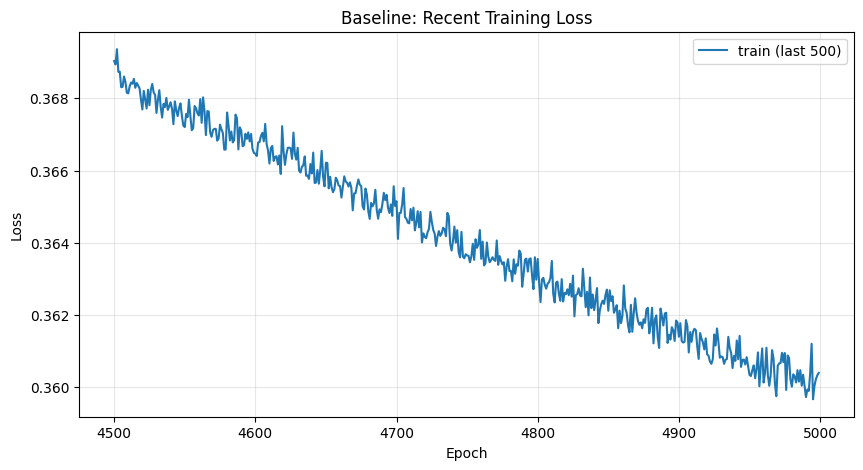

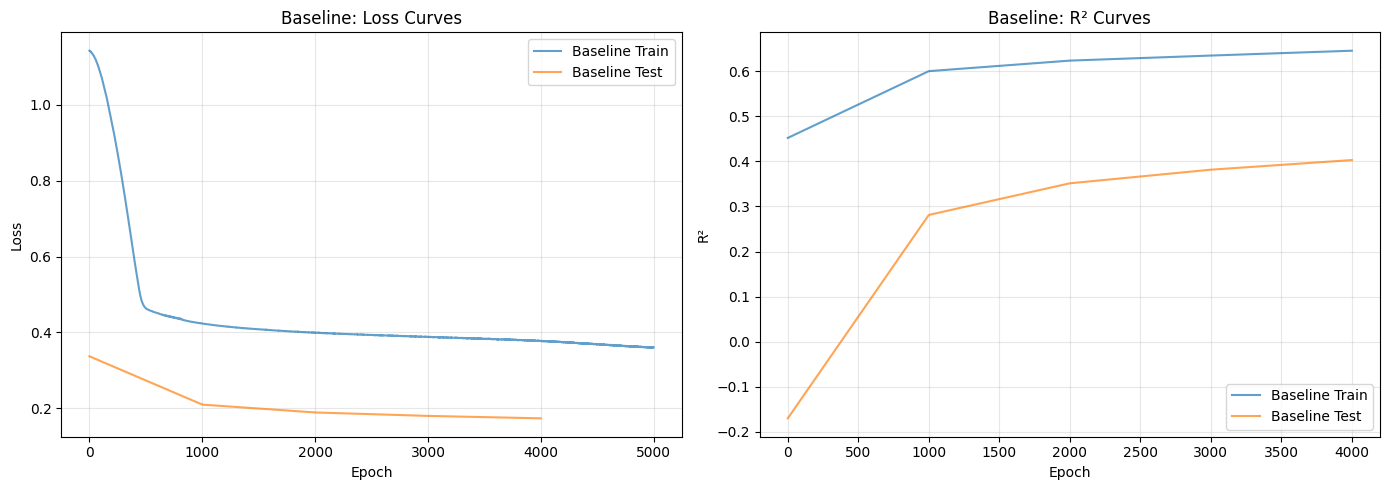

In [ ]:
# Baseline training curves (original)
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
plt.figure(figsize=(10, 5))
plt.plot(txt[-500:], tlt[-500:], label="train (last 500)")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Baseline: Recent Training Loss")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Full baseline curves
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]

axes[0].plot(txt, tlt, label="Baseline Train", alpha=0.7)
axes[0].plot(tx, tl, label="Baseline Test", alpha=0.7)
axes[0].set_xlabel("Epoch")
axes[0].set_ylabel("Loss")
axes[0].set_title("Baseline: Loss Curves")
axes[0].legend()
axes[0].grid(True, alpha=0.3)

tx_r2 = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
te = [t[1] for t in results['test_r2s']]

axes[1].plot(tx_r2, tr, label="Baseline Train", alpha=0.7)
axes[1].plot(tx_r2, te, label="Baseline Test", alpha=0.7)
axes[1].set_xlabel("Epoch")
axes[1].set_ylabel("R²")
axes[1].set_title("Baseline: R² Curves")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

Available models:
  baseline: ✓
  spatial: ✗
  ae_recon: ✓



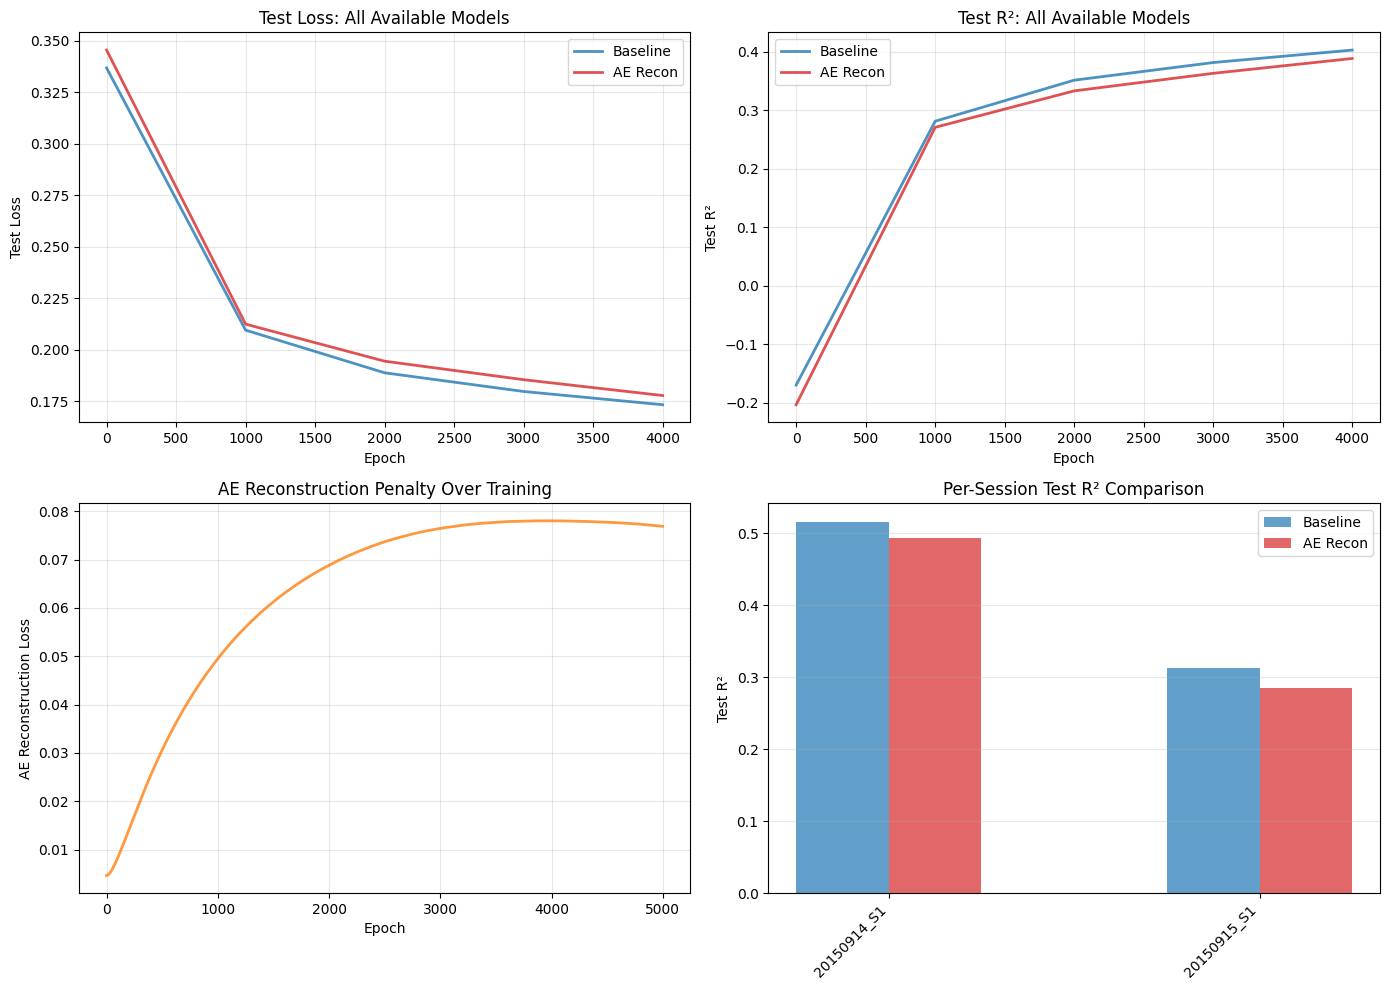


FINAL COMPARISON: Available Models
Baseline             Test R² = 0.402943
AE Recon             Test R² = 0.388548

Improvement over Baseline:
  AE Recon           -0.014396 (-3.57%)


In [ ]:
# Visualize AE reconstruction penalty alongside other metrics
# Handle missing data gracefully
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Check which models are available
models_available = {
    'baseline': 'results' in globals(),
    'spatial': 'results_spatial' in globals(),
    'ae_recon': 'results_ae_recon' in globals(),
}

print("Available models:")
for name, available in models_available.items():
    print(f"  {name}: {'✓' if available else '✗'}")
print()

# Extract baseline data if available
if models_available['baseline']:
    txt = [t[0] for t in results['train_losses']]
    tlt = [t[1] for t in results['train_losses']]
    tx = [t[0] for t in results['test_losses']]
    tl = [t[1] for t in results['test_losses']]
    tx_r2 = [t[0] for t in results['train_r2s']]
    tr = [t[1] for t in results['train_r2s']]
    te = [t[1] for t in results['test_r2s']]

# Extract spatial data if available
if models_available['spatial']:
    txt_s = [t[0] for t in results_spatial['train_losses']]
    tlt_s = [t[1] for t in results_spatial['train_losses']]
    tx_s = [t[0] for t in results_spatial['test_losses']]
    tl_s = [t[1] for t in results_spatial['test_losses']]
    tx_r2_s = [t[0] for t in results_spatial['train_r2s']]
    tr_s = [t[1] for t in results_spatial['train_r2s']]
    te_s = [t[1] for t in results_spatial['test_r2s']]

# Extract AE recon data if available
if models_available['ae_recon']:
    txt_ae = [t[0] for t in results_ae_recon['train_losses']]
    tlt_ae = [t[1] for t in results_ae_recon['train_losses']]
    tx_ae = [t[0] for t in results_ae_recon['test_losses']]
    tl_ae = [t[1] for t in results_ae_recon['test_losses']]
    tx_r2_ae = [t[0] for t in results_ae_recon['train_r2s']]
    tr_ae = [t[1] for t in results_ae_recon['train_r2s']]
    te_ae = [t[1] for t in results_ae_recon['test_r2s']]

# Test Loss Comparison
if models_available['baseline']:
    axes[0, 0].plot(tx, tl, label="Baseline", alpha=0.8, linewidth=2, color='C0')
if models_available['spatial']:
    axes[0, 0].plot(tx_s, tl_s, label="Spatial", alpha=0.8, linewidth=2, color='C2')
if models_available['ae_recon']:
    axes[0, 0].plot(tx_ae, tl_ae, label="AE Recon", alpha=0.8, linewidth=2, color='C3')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Test Loss")
axes[0, 0].set_title("Test Loss: All Available Models")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test R² Comparison
if models_available['baseline']:
    axes[0, 1].plot(tx_r2, te, label="Baseline", alpha=0.8, linewidth=2, color='C0')
if models_available['spatial']:
    axes[0, 1].plot(tx_r2_s, te_s, label="Spatial", alpha=0.8, linewidth=2, color='C2')
if models_available['ae_recon']:
    axes[0, 1].plot(tx_r2_ae, te_ae, label="AE Recon", alpha=0.8, linewidth=2, color='C3')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Test R²")
axes[0, 1].set_title("Test R²: All Available Models")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# AE Reconstruction penalty over training (if available)
if models_available['ae_recon']:
    ae_recon_x = [t[0] for t in results_ae_recon['ae_recon_losses']]
    ae_recon_y = [t[1] for t in results_ae_recon['ae_recon_losses']]
    axes[1, 0].plot(ae_recon_x, ae_recon_y, alpha=0.8, linewidth=2, color='C1')
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("AE Reconstruction Loss")
    axes[1, 0].set_title("AE Reconstruction Penalty Over Training")
    axes[1, 0].grid(True, alpha=0.3)
else:
    axes[1, 0].text(0.5, 0.5, "AE Recon model not trained", 
                    ha='center', va='center', transform=axes[1, 0].transAxes)
    axes[1, 0].set_title("AE Reconstruction Penalty (N/A)")

# Per-session R² comparison bar chart
if any(models_available.values()):
    # Get session list from first available model
    if models_available['baseline']:
        sessions = list(results['final_test_r2s'].keys())
    elif models_available['spatial']:
        sessions = list(results_spatial['final_test_r2s'].keys())
    else:
        sessions = list(results_ae_recon['final_test_r2s'].keys())
    
    x = range(len(sessions))
    width = 0.25
    offset = 0
    
    if models_available['baseline']:
        baseline_vals = [results['final_test_r2s'][s] for s in sessions]
        axes[1, 1].bar([i + offset*width for i in x], baseline_vals, width, 
                      label='Baseline', color='C0', alpha=0.7)
        offset += 1
    
    if models_available['spatial']:
        spatial_vals = [results_spatial['final_test_r2s'][s] for s in sessions]
        axes[1, 1].bar([i + offset*width for i in x], spatial_vals, width, 
                      label='Spatial', color='C2', alpha=0.7)
        offset += 1
    
    if models_available['ae_recon']:
        ae_recon_vals = [results_ae_recon['final_test_r2s'][s] for s in sessions]
        axes[1, 1].bar([i + offset*width for i in x], ae_recon_vals, width, 
                      label='AE Recon', color='C3', alpha=0.7)
        offset += 1
    
    axes[1, 1].set_ylabel("Test R²")
    axes[1, 1].set_title("Per-Session Test R² Comparison")
    axes[1, 1].set_xticks([i + (offset-1)*width/2 for i in x])
    axes[1, 1].set_xticklabels([s.split('_')[1] + '_' + s.split('_')[-1] for s in sessions], 
                               rotation=45, ha='right')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3, axis='y')
else:
    axes[1, 1].text(0.5, 0.5, "No models trained yet", 
                    ha='center', va='center', transform=axes[1, 1].transAxes)
    axes[1, 1].set_title("Per-Session Comparison (N/A)")

plt.tight_layout()
plt.show()

# Print comparison table
print("\n" + "="*80)
print("FINAL COMPARISON: Available Models")
print("="*80)

comparison_data = []
if models_available['baseline']:
    comparison_data.append(("Baseline", results['final_test_r2']))
if models_available['spatial']:
    comparison_data.append(("Spatial", results_spatial['final_test_r2']))
if models_available['ae_recon']:
    comparison_data.append(("AE Recon", results_ae_recon['final_test_r2']))

if comparison_data:
    for name, r2 in comparison_data:
        print(f"{name:20s} Test R² = {r2:.6f}")
    
    if len(comparison_data) > 1:
        print("="*80)
        print("\nImprovement over Baseline:")
        baseline_r2 = comparison_data[0][1] if comparison_data[0][0] == "Baseline" else None
        if baseline_r2:
            for name, r2 in comparison_data[1:]:
                improvement = r2 - baseline_r2
                pct = improvement / baseline_r2 * 100
                print(f"  {name:18s} {improvement:+.6f} ({pct:+.2f}%)")
else:
    print("No models trained yet. Run training cells above.")

print("="*80)

In [ ]:
# Visualize training curves with both penalties
# Handle missing Stage 1 data

if 'results_s1' not in globals():
    print("="*80)
    print("Stage 1 not trained yet - run Stage 1 training cell first")
    print("="*80)
else:
    fig, axes = plt.subplots(2, 2, figsize=(14, 10))

    # Test R² over training
    tx_r2_s1 = [t[0] for t in results_s1['train_r2s']]
    te_s1 = [t[1] for t in results_s1['test_r2s']]

    axes[0, 0].plot(tx_r2_s1, te_s1, label="Stage 1 (Sparsity)", linewidth=2, color='C3')
    axes[0, 0].set_xlabel("Epoch")
    axes[0, 0].set_ylabel("Test R²")
    axes[0, 0].set_title("Test R²: Sparsity-Based Training")
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Test Loss over training
    tx_s1 = [t[0] for t in results_s1['test_losses']]
    tl_s1 = [t[1] for t in results_s1['test_losses']]

    axes[0, 1].plot(tx_s1, tl_s1, label="Stage 1 (Sparsity)", linewidth=2, color='C3')
    axes[0, 1].set_xlabel("Epoch")
    axes[0, 1].set_ylabel("Test Loss")
    axes[0, 1].set_title("Test Loss: Sparsity-Based Training")
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Channel sparsity penalty over training
    sparsity_x = [t[0] for t in results_s1['channel_sparsity_losses']]
    sparsity_y = [t[1] for t in results_s1['channel_sparsity_losses']]

    axes[1, 0].plot(sparsity_x, sparsity_y, linewidth=2, color='C4')
    axes[1, 0].set_xlabel("Epoch")
    axes[1, 0].set_ylabel("Channel Sparsity Penalty (L1)")
    axes[1, 0].set_title("L1 Sparsity Penalty Over Training")
    axes[1, 0].grid(True, alpha=0.3)

    # Sparsity-weighted reconstruction penalty over training
    recon_x = [t[0] for t in results_s1['sparsity_recon_losses']]
    recon_y = [t[1] for t in results_s1['sparsity_recon_losses']]

    axes[1, 1].plot(recon_x, recon_y, linewidth=2, color='C5')
    axes[1, 1].set_xlabel("Epoch")
    axes[1, 1].set_ylabel("Sparsity-Weighted Reconstruction Loss")
    axes[1, 1].set_title("Reconstruction Penalty Over Training")
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print(f"\nStage 1 Complete:")
    print(f"  Test R²: {results_s1['final_test_r2']:.6f}")
    print(f"  Final sparsity penalty: {sparsity_y[-1]:.6f}")
    print(f"  Final reconstruction penalty: {recon_y[-1]:.6f}")

### Analyze Learned Sparsity Patterns

Examine which channels have low activation and can be safely compressed.

In [ ]:
# Analyze channel activations from Stage 1 to identify important channels
import numpy as np

# Check if Stage 1 results are available
if 'results_s1' not in globals():
    print("="*80)
    print("Stage 1 not trained yet - run Stage 1 training cell first")
    print("="*80)
else:
    logger.info("\n" + "="*80)
    logger.info("SPARSITY ANALYSIS")
    logger.info("="*80)

    important_channels = {}
    channel_importance_scores = {}

    for session_id in held_in_session_ids:
        # Get final channel activations (from last tracking point)
        if len(results_s1['channel_activations'][session_id]) > 0:
            final_epoch, final_activations = results_s1['channel_activations'][session_id][-1]
            channel_importance = final_activations.numpy()
            
            # Store importance scores
            channel_importance_scores[session_id] = channel_importance
            
            # Identify important channels (above median activation)
            median_activation = np.median(channel_importance)
            important_mask = channel_importance > median_activation
            important_idx = np.where(important_mask)[0]
            
            important_channels[session_id] = important_idx.tolist()
            
            logger.info(f"\n{session_id}:")
            logger.info(f"  Total channels: {len(channel_importance)}")
            logger.info(f"  Important channels (>median): {len(important_idx)}")
            logger.info(f"  Compression ratio: {len(important_idx)/len(channel_importance):.2%}")
            logger.info(f"  Median activation: {median_activation:.6f}")
            logger.info(f"  Max activation: {channel_importance.max():.6f}")
            logger.info(f"  Min activation: {channel_importance.min():.6f}")

    logger.info("="*80)

    # Visualize channel importance across sessions
    fig, axes = plt.subplots(len(held_in_session_ids), 1, figsize=(12, 3*len(held_in_session_ids)))
    if len(held_in_session_ids) == 1:
        axes = [axes]

    for idx, session_id in enumerate(held_in_session_ids):
        if session_id in channel_importance_scores:
            importance = channel_importance_scores[session_id]
            important_idx = important_channels[session_id]
            
            axes[idx].bar(range(len(importance)), importance, alpha=0.6, color='gray', label='All channels')
            axes[idx].bar(important_idx, importance[important_idx], alpha=0.8, color='C3', label='Important channels')
            axes[idx].axhline(np.median(importance), color='red', linestyle='--', label='Median', linewidth=2)
            axes[idx].set_xlabel("Channel Index")
            axes[idx].set_ylabel("Mean Activation")
            axes[idx].set_title(f"{session_id.split('_')[1]}_{session_id.split('_')[-1]}")
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    print("\nChannel importance scores computed. Ready for Stage 2.")

## Overall Summary

Compare all trained models (automatically detects which ones are available)

MODEL COMPARISON SUMMARY

Available Models:
  ✓ Baseline (PCA AE)    - Standard TBFM with PCA-initialized AE
  ✗ Spatial Reg          - Spatial smoothness regularization
  ✓ AE Recon             - AE reconstruction penalty only
  ✗ Sparsity Stage 1     - Identity AE + sparsity penalties

PERFORMANCE COMPARISON
            Model  Test R²  Best R²
Baseline (PCA AE) 0.402943 0.402943
         AE Recon 0.388548 0.388548

IMPROVEMENT OVER BASELINE
  AE Recon            : -0.014396 (-3.57%)

PER-SESSION COMPARISON

MonkeyG_20150914_Session1_S1:
  Baseline (PCA AE)   : 0.515857
  AE Recon            : 0.492505

MonkeyG_20150915_Session3_S1:
  Baseline (PCA AE)   : 0.313325
  AE Recon            : 0.284590



NameError: name 'np' is not defined

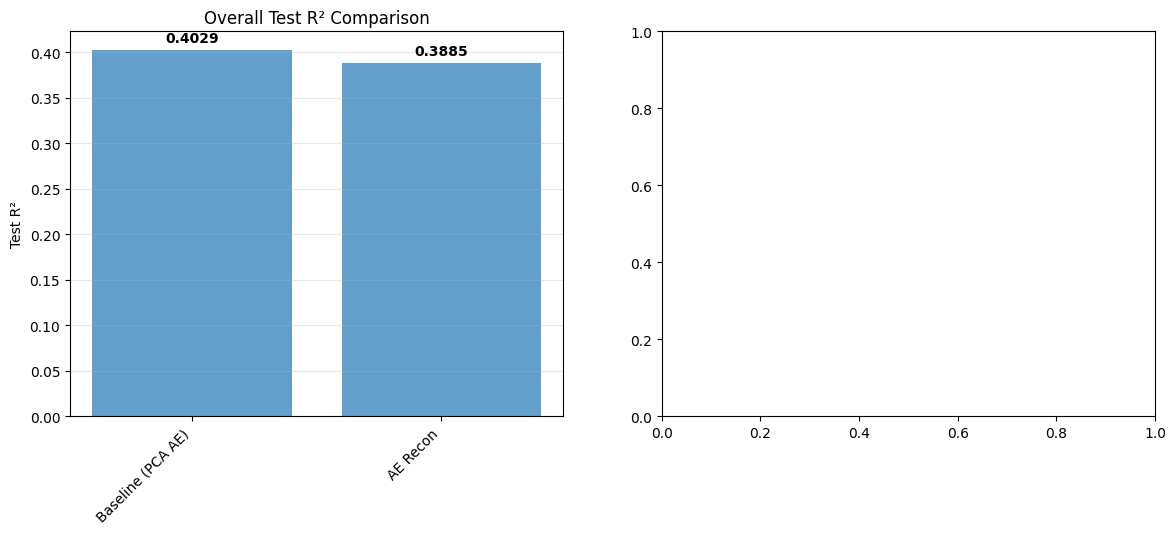

In [ ]:
# Comprehensive model comparison - automatically detects available models
import pandas as pd

# Check which models are available
models_info = {
    'Baseline (PCA AE)': ('results', 'Standard TBFM with PCA-initialized AE'),
    'Spatial Reg': ('results_spatial', 'Spatial smoothness regularization'),
    'AE Recon': ('results_ae_recon', 'AE reconstruction penalty only'),
    'Sparsity Stage 1': ('results_s1', 'Identity AE + sparsity penalties'),
}

print("="*80)
print("MODEL COMPARISON SUMMARY")
print("="*80)
print("\nAvailable Models:")

available_models = []
for name, (var_name, description) in models_info.items():
    is_available = var_name in globals()
    status = "✓" if is_available else "✗"
    print(f"  {status} {name:20s} - {description}")
    if is_available:
        available_models.append((name, var_name, globals()[var_name]))

if not available_models:
    print("\nNo models trained yet. Run training cells above.")
else:
    print("\n" + "="*80)
    print("PERFORMANCE COMPARISON")
    print("="*80)
    
    # Create comparison table
    comparison_rows = []
    for name, var_name, results in available_models:
        comparison_rows.append({
            'Model': name,
            'Test R²': f"{results['final_test_r2']:.6f}",
            'Best R²': f"{results.get('best_test_r2', results['final_test_r2']):.6f}",
        })
    
    df = pd.DataFrame(comparison_rows)
    print(df.to_string(index=False))
    
    # Calculate improvements if baseline exists
    baseline_results = next((r for n, v, r in available_models if n == 'Baseline (PCA AE)'), None)
    if baseline_results and len(available_models) > 1:
        print("\n" + "="*80)
        print("IMPROVEMENT OVER BASELINE")
        print("="*80)
        baseline_r2 = baseline_results['final_test_r2']
        
        for name, var_name, results in available_models:
            if name != 'Baseline (PCA AE)':
                r2 = results['final_test_r2']
                improvement = r2 - baseline_r2
                pct = (improvement / baseline_r2) * 100
                symbol = "+" if improvement > 0 else ""
                print(f"  {name:20s}: {symbol}{improvement:.6f} ({symbol}{pct:.2f}%)")
    
    # Per-session breakdown if multiple models
    if len(available_models) > 1:
        print("\n" + "="*80)
        print("PER-SESSION COMPARISON")
        print("="*80)
        
        # Get session list from first available model
        sessions = list(available_models[0][2]['final_test_r2s'].keys())
        
        for session_id in sessions:
            print(f"\n{session_id}:")
            for name, var_name, results in available_models:
                if session_id in results['final_test_r2s']:
                    r2 = results['final_test_r2s'][session_id]
                    print(f"  {name:20s}: {r2:.6f}")
    
    print("\n" + "="*80)
    
    # Visualize all available models
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    # Overall comparison bar chart
    model_names = [name for name, _, _ in available_models]
    test_r2s = [results['final_test_r2'] for _, _, results in available_models]
    
    axes[0].bar(range(len(model_names)), test_r2s, alpha=0.7)
    axes[0].set_xticks(range(len(model_names)))
    axes[0].set_xticklabels(model_names, rotation=45, ha='right')
    axes[0].set_ylabel("Test R²")
    axes[0].set_title("Overall Test R² Comparison")
    axes[0].grid(True, alpha=0.3, axis='y')
    
    # Add values on bars
    for i, v in enumerate(test_r2s):
        axes[0].text(i, v + 0.005, f"{v:.4f}", ha='center', va='bottom', fontweight='bold')
    
    # Per-session heatmap
    if len(available_models) > 1:
        sessions = list(available_models[0][2]['final_test_r2s'].keys())
        session_data = []
        for name, var_name, results in available_models:
            session_r2s = [results['final_test_r2s'].get(s, 0) for s in sessions]
            session_data.append(session_r2s)
        
        session_data = np.array(session_data).T  # Sessions x Models
        
        im = axes[1].imshow(session_data, aspect='auto', cmap='viridis')
        axes[1].set_xticks(range(len(model_names)))
        axes[1].set_xticklabels(model_names, rotation=45, ha='right')
        axes[1].set_yticks(range(len(sessions)))
        axes[1].set_yticklabels([s.split('_')[1] + '_' + s.split('_')[-1] for s in sessions])
        axes[1].set_title("Per-Session Test R²")
        
        # Add colorbar
        cbar = plt.colorbar(im, ax=axes[1])
        cbar.set_label("Test R²")
        
        # Add text annotations
        for i in range(len(sessions)):
            for j in range(len(model_names)):
                text = axes[1].text(j, i, f"{session_data[i, j]:.3f}",
                                   ha="center", va="center", color="w", fontsize=8)
    
    plt.tight_layout()
    plt.show()

## Comparison: Baseline vs Spatial Regularization

In [ ]:
logger.info("\n" + "="*80)
logger.info("COMPARISON: BASELINE vs SPATIAL")
logger.info("="*80)

# Compare overall performance
baseline_r2 = results['final_test_r2']
spatial_r2 = results_spatial['final_test_r2']

logger.info(f"\nOverall Test R²:")
logger.info(f"  Baseline: {baseline_r2:.6f}")
logger.info(f"  Spatial:  {spatial_r2:.6f}")
logger.info(f"  Improvement: {(spatial_r2 - baseline_r2):.6f} ({(spatial_r2 - baseline_r2)/baseline_r2*100:.2f}%)")

# Per-session comparison
logger.info(f"\nPer-session Test R²:")
for session_id in held_in_session_ids:
    base_r2 = results['final_test_r2s'][session_id]
    spat_r2 = results_spatial['final_test_r2s'][session_id]
    improvement = spat_r2 - base_r2
    logger.info(f"  {session_id}:")
    logger.info(f"    Baseline: {base_r2:.6f}")
    logger.info(f"    Spatial:  {spat_r2:.6f}")
    logger.info(f"    Improvement: {improvement:.6f} ({improvement/base_r2*100:.2f}%)")

logger.info("="*80)

2025-10-28 03:57:16 - 
2025-10-28 03:57:16 - COMPARISON: BASELINE vs SPATIAL
2025-10-28 03:57:16 - ================================================================================
2025-10-28 03:57:16 - 
Overall Test R²:
2025-10-28 03:57:16 -   Baseline: 0.488822
2025-10-28 03:57:16 -   Spatial:  0.468797
2025-10-28 03:57:16 -   Improvement: -0.020025 (-4.10%)
2025-10-28 03:57:16 - 
Per-session Test R²:
2025-10-28 03:57:16 -   MonkeyG_20150914_Session1_S1:
2025-10-28 03:57:16 -     Baseline: 0.512441
2025-10-28 03:57:16 -     Spatial:  0.498375
2025-10-28 03:57:16 -     Improvement: -0.014066 (-2.74%)
2025-10-28 03:57:16 -   MonkeyG_20150915_Session3_S1:
2025-10-28 03:57:16 -     Baseline: 0.306624
2025-10-28 03:57:16 -     Spatial:  0.298206
2025-10-28 03:57:16 -     Improvement: -0.008418 (-2.75%)
2025-10-28 03:57:16 -   MonkeyG_20150915_Session5_S1:
2025-10-28 03:57:16 -     Baseline: 0.753378
2025-10-28 03:57:16 -     Spatial:  0.721152
2025-10-28 03:57:16 -     Improvement: -0.0322

## Comparison Visualizations

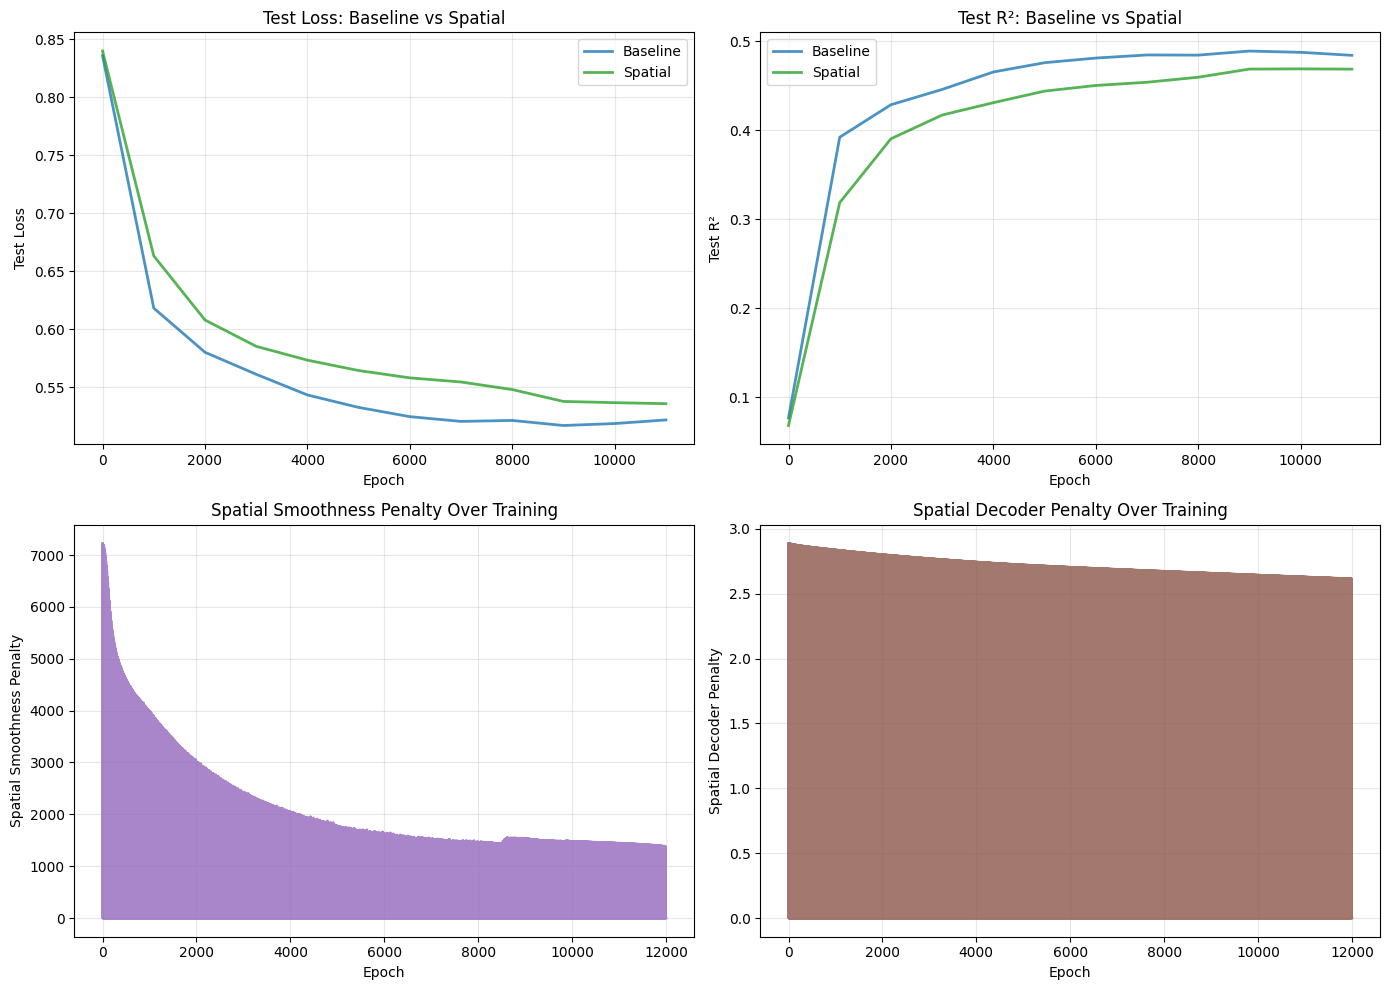

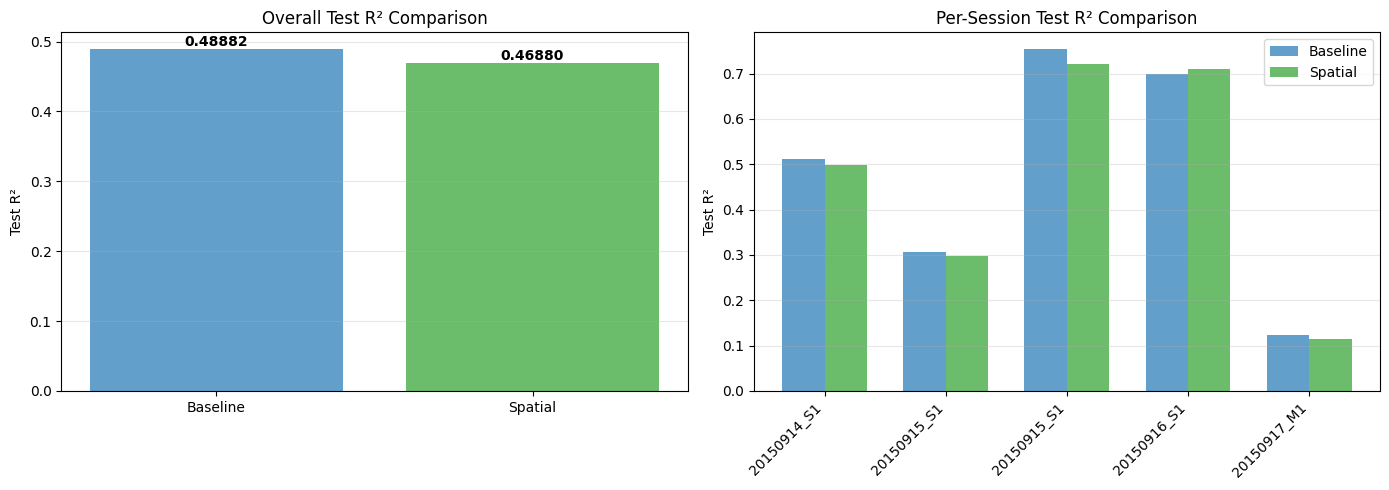


Summary Statistics
Baseline - Final Test R²: 0.488822
Spatial  - Final Test R²: 0.468797
Improvement: -0.020025 (-4.10%)


In [ ]:
# Direct comparison: Baseline vs Spatial
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Extract data
txt = [t[0] for t in results['train_losses']]
tlt = [t[1] for t in results['train_losses']]
tx = [t[0] for t in results['test_losses']]
tl = [t[1] for t in results['test_losses']]
tx_r2 = [t[0] for t in results['train_r2s']]
tr = [t[1] for t in results['train_r2s']]
te = [t[1] for t in results['test_r2s']]

txt_s = [t[0] for t in results_spatial['train_losses']]
tlt_s = [t[1] for t in results_spatial['train_losses']]
tx_s = [t[0] for t in results_spatial['test_losses']]
tl_s = [t[1] for t in results_spatial['test_losses']]
tx_r2_s = [t[0] for t in results_spatial['train_r2s']]
tr_s = [t[1] for t in results_spatial['train_r2s']]
te_s = [t[1] for t in results_spatial['test_r2s']]

# Test Loss Comparison
axes[0, 0].plot(tx, tl, label="Baseline", alpha=0.8, linewidth=2, color='C0')
axes[0, 0].plot(tx_s, tl_s, label="Spatial", alpha=0.8, linewidth=2, color='C2')
axes[0, 0].set_xlabel("Epoch")
axes[0, 0].set_ylabel("Test Loss")
axes[0, 0].set_title("Test Loss: Baseline vs Spatial")
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Test R² Comparison
axes[0, 1].plot(tx_r2, te, label="Baseline", alpha=0.8, linewidth=2, color='C0')
axes[0, 1].plot(tx_r2_s, te_s, label="Spatial", alpha=0.8, linewidth=2, color='C2')
axes[0, 1].set_xlabel("Epoch")
axes[0, 1].set_ylabel("Test R²")
axes[0, 1].set_title("Test R²: Baseline vs Spatial")
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Spatial penalty curves
smoothx = [t[0] for t in results_spatial['spatial_smooth_losses']]
smoothy = [t[1] for t in results_spatial['spatial_smooth_losses']]
decx = [t[0] for t in results_spatial['spatial_decoder_losses']]
decy = [t[1] for t in results_spatial['spatial_decoder_losses']]

axes[1, 0].plot(smoothx, smoothy, alpha=0.8, linewidth=2, color='C4')
axes[1, 0].set_xlabel("Epoch")
axes[1, 0].set_ylabel("Spatial Smoothness Penalty")
axes[1, 0].set_title("Spatial Smoothness Penalty Over Training")
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].plot(decx, decy, alpha=0.8, linewidth=2, color='C5')
axes[1, 1].set_xlabel("Epoch")
axes[1, 1].set_ylabel("Spatial Decoder Penalty")
axes[1, 1].set_title("Spatial Decoder Penalty Over Training")
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final comparison bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Overall comparison
overall_data = [baseline_r2, spatial_r2]
axes[0].bar(['Baseline', 'Spatial'], overall_data, color=['C0', 'C2'], alpha=0.7)
axes[0].set_ylabel("Test R²")
axes[0].set_title("Overall Test R² Comparison")
axes[0].grid(True, alpha=0.3, axis='y')
for i, v in enumerate(overall_data):
    axes[0].text(i, v + 0.001, f"{v:.5f}", ha='center', va='bottom', fontweight='bold')

# Per-session comparison
sessions = list(results['final_test_r2s'].keys())
baseline_vals = [results['final_test_r2s'][s] for s in sessions]
spatial_vals = [results_spatial['final_test_r2s'][s] for s in sessions]

x = range(len(sessions))
width = 0.35

axes[1].bar([i - width/2 for i in x], baseline_vals, width, label='Baseline', color='C0', alpha=0.7)
axes[1].bar([i + width/2 for i in x], spatial_vals, width, label='Spatial', color='C2', alpha=0.7)
axes[1].set_ylabel("Test R²")
axes[1].set_title("Per-Session Test R² Comparison")
axes[1].set_xticks(x)
axes[1].set_xticklabels([s.split('_')[1] + '_' + s.split('_')[-1] for s in sessions], rotation=45, ha='right')
axes[1].legend()
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\n" + "="*80)
print("Summary Statistics")
print("="*80)
print(f"Baseline - Final Test R²: {baseline_r2:.6f}")
print(f"Spatial  - Final Test R²: {spatial_r2:.6f}")
print(f"Improvement: {(spatial_r2 - baseline_r2):.6f} ({(spatial_r2 - baseline_r2)/baseline_r2*100:.2f}%)")
print("="*80)

## Load Saved Models

To load the saved models later, use:

```python
# Load baseline model
checkpoint = torch.load(model_save_dir / "baseline_model.pt")
ms_loaded = multisession.build_from_cfg(cfg, data_train, device=DEVICE)
ms_loaded.load_state_dict(checkpoint['ms_state_dict'])
embeddings_stim_loaded = checkpoint['embeddings_stim']
results_loaded = checkpoint['results']

# Load spatial model
checkpoint_spatial = torch.load(model_save_dir / "spatial_model.pt")
cfg_spatial_loaded = OmegaConf.create(checkpoint_spatial['config'])
ms_spatial_loaded = multisession.build_from_cfg(cfg_spatial_loaded, data_train, device=DEVICE)
ms_spatial_loaded.load_state_dict(checkpoint_spatial['ms_state_dict'])
```